In [98]:
att_cnn_bilstm_cross_validate_model_path = "saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5"
cnn_bilstm_cross_validate_model_path = "saved_model/best_CNN_BiLSTM_Cross_validation.hdf5"
cnn_cross_validate_model_path = "saved_model/best_CNN_Cross_validation.hdf5"
bisltm_cross_validate_model_path = "saved_model/best_BiLSTM_Cross_validation.hdf5"

# defining the hyperparameters
learning_rate = 1e-3
learning_decay = 1e-10 # 1e-4
batch_size= 64 # 128
epochs = 10

spa_dropout_ratio = 0.2 # dropout ration, dropping a entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.1 # 0.1 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.
embed_dim = 300 

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputSpec, Layer, Input, Embedding, Conv1D, Conv2D, Bidirectional, Dense, Attention
from tensorflow.keras.layers import LSTM, Activation, Add, Flatten, Concatenate, concatenate # CuDNNGRU, CuDNNLSTM, 
from tensorflow.keras.layers import Reshape, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D, MaxPool2D, GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K 
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam

import string
# from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

from glob import glob
from tqdm import tqdm

from time import time
from timeit import default_timer as timer
from datetime import datetime

import re, copy
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report



In [99]:
import pandas as pd
import numpy as np
train_set = pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/thai2fit/thai2fit_80_percent_1.csv", header= None,names=["text", "label"])
test_unseen = pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/thai2fit/thai2fit_20_percent_1.csv",  header= None,names=["text", "label"])

# all_dataset =  pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/original/original_1/original_dataset.csv",  header= None,names=["text", "label"])

In [100]:
from sklearn.model_selection import train_test_split
message_train, message_test, label_train, label_test = train_test_split(train_set["text"], train_set["label"], test_size=0.15,stratify=train_set["label"])

test = pd.DataFrame()
test["text"]=message_test
test["label"]=label_test


In [101]:
message_train_2, message_validation, label_train_2, label_validation = train_test_split(message_train, label_train, test_size=0.1765,stratify=label_train)
train = pd.DataFrame()
train["text"]=message_train_2
train["label"]=label_train_2

validate = pd.DataFrame()
validate["text"]=message_validation
validate["label"]=label_validation

In [102]:
validate["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           976
ลงทะเบียนเรียน              701
ชำระเงิน/ใบเสร็จรับเงิน     531
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    380
ประวัตินักศึกษา             131
เกรด                         86
สถานภาพนักศึกษา              68
Name: count, dtype: int64

In [103]:
train["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           4552
ลงทะเบียนเรียน              3268
ชำระเงิน/ใบเสร็จรับเงิน     2477
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    1771
ประวัตินักศึกษา              613
เกรด                         404
สถานภาพนักศึกษา              316
Name: count, dtype: int64

In [104]:
test_unseen["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           1626
ลงทะเบียนเรียน              1167
ชำระเงิน/ใบเสร็จรับเงิน      885
แจ้งจบ/ขึ้นทะเบียนบัณฑิต     633
ประวัตินักศึกษา              219
เกรด                         144
สถานภาพนักศึกษา              113
Name: count, dtype: int64

In [105]:
test["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           975
ลงทะเบียนเรียน              701
ชำระเงิน/ใบเสร็จรับเงิน     531
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    380
ประวัตินักศึกษา             131
เกรด                         86
สถานภาพนักศึกษา              68
Name: count, dtype: int64

In [106]:
# all_dataset["label"].value_counts()

In [107]:
!pip install sklearn_crfsuite
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai=÷=1.0.46

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
# nltk.download('punkt')
# nltk.download('stopwords')
from pythainlp.corpus import thai_stopwords
stopwords = thai_stopwords()

zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory


You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory
  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Installing build dependencies ... done
pythainlp requires Python '>=3.7' but the running Python is 2.7.16
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [108]:

# from pythainlp.corpus import thai_stopwords
from pythainlp import word_tokenize

def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in word_tokenize(text,engine='newmm') if word not in (stopwords)])
    return text

In [109]:
def clean_text(text):
    # print(text)
    # text = lower_text(text)
    text_str = str(text)
    text = remove_number(text_str)
    text = remove_punct(text_str)
    text = remove_stopwords(text_str)

    return text

In [110]:
# all_dataset["clean_text"] = all_dataset["text"].apply(clean_text)
test_unseen["clean_text"] = test_unseen["text"].apply(clean_text)
train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)
validate["clean_text"] =  validate["text"].apply(clean_text)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# all_dataset["encoded_original_label"] = label_encoder.fit_transform(all_dataset["label"])
test_unseen["encoded_original_label"] = label_encoder.fit_transform(test_unseen["label"])
test["encoded_original_label"] = label_encoder.fit_transform(test["label"])
train["encoded_original_label"] = label_encoder.fit_transform(train["label"])
validate["encoded_original_label"] = label_encoder.fit_transform(validate["label"])

In [111]:
from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential


act= "relu"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [112]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [113]:
!pip3 install textblob  

zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip3: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Feed-Forward Networks with Attention Can Solve Some Long-Term Memory Problems
###### https://arxiv.org/abs/1512.08756

In [114]:
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

## Hierarchical Attention Networks for Document Classification
##### http://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

In [115]:
# https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
# https://www.kaggle.com/code/duykhanh99/bidirectional-lstm-cnn-attention-model/notebook
    
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
    
def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def accuracy(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "accuracy":accuracy}


class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
        
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "arg1": self.arg1,
#             "arg2": self.arg2,
#         })
#         return config     
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Training the models

In [116]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])
df_results_cross_val = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])

In [117]:
test["encoded_original_label"]

9430     0
17051    1
8626     0
11665    0
1438     0
        ..
9943     3
12343    1
17874    3
14752    0
3033     3
Name: encoded_original_label, Length: 2872, dtype: int64

In [118]:
X_train, X_test_unseen, X_test, X_validate = train["clean_text"], test_unseen["clean_text"], test["clean_text"], validate["clean_text"]


y_train, y_test_unseen, y_test, y_validate = train["encoded_original_label"], test_unseen["encoded_original_label"],test["encoded_original_label"],validate["encoded_original_label"]


temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate = X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate

# temp_message, temp_label = all_dataset["clean_text"], all_dataset["encoded_original_label"]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)

{'เอกสาร': 1, 'สอบถาม': 2, 'ค่า': 3, 'สวัสดี': 4, 'เทอม': 5, 'จบ': 6, 'วิชา': 7, 'จ่าย': 8, 'นักศึกษา': 9, '\r': 10, 'ทำ': 11, 'ใบ': 12, 'ไหม': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'เรื่อง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'ขึ้นทะเบียน': 21, 'ทราบ': 22, 'วันที่': 23, 'บัณฑิต': 24, 'ออนไลน์': 25, 'อะ': 26, 'ค่าชดเชย': 27, 'ตอนนี้': 28, 'กด': 29, 'เดี๋ยว': 30, 'ชำระ': 31, 'reg': 32, 'รอ': 33, 'ตอน': 34, 'คณะ': 35, 'ต้องการ': 36, '1': 37, '2': 38, 'ไห': 39, 'นิรันดร': 40, 'รบกวน': 41, 'เงิน': 42, 'citing': 43, 'รายวิชา': 44, 'รหัส': 45, 'ปี': 46, 'ติดต่อ': 47, 'ชำระเงิน': 48, 'เบิก': 49, 'ระบบ': 50, 'สักวัน': 51, 'การศึกษา': 52, '3': 53, 'gen': 54, 'มหาลัย': 55, 'เว็บ': 56, 'elisabeth': 57, 'จดทะเบียน': 58, 'พยาบาท': 59, 'กี่': 60, 'ฝังใจ': 61, 'ป': 62, 'แบบนี้': 63, 'เกรด': 64, 'โดยไม่รู้ตัว': 65, 'ตัว': 66, 'ล่าช้า': 67, 'อ่ะ': 68, 'ตรวจสอบ': 69, 'ขออนุญาต': 70, 'tu': 71, 'tar': 72, 'ชื่อ': 73, 'ค': 74, 'เลือก': 75, 'แคลคูลัส': 76, 'ดำเนินการ': 77, 'เรียบร้อย': 78, 'ขอบคุณ'

In [119]:
train["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           4552
ลงทะเบียนเรียน              3268
ชำระเงิน/ใบเสร็จรับเงิน     2477
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    1771
ประวัตินักศึกษา              613
เกรด                         404
สถานภาพนักศึกษา              316
Name: count, dtype: int64

## Att CNN-BiLSTM MODEL

In [120]:
def build_model_1(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length=max_length,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr_d),
#         optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "saved_model/best_Attention_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="Att_cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history_1 = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validate, y_validate),
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test_unseen, y_test_unseen) # or model.predict
    
    return model, history_1, train_time

In [121]:
# Train proposed model
model_1, history_1, train_time = build_model_1(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 61)]              0         
                                                                 
 embedding (Embedding)       (None, 61, 300)           1065600   
                                                                 
 spatial_dropout1d_24 (Spat  (None, 61, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_24 (Conv1D)          (None, 59, 50)            45050     
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 29, 50)            0         
 ng1D)                                                           
                                                                 
 dropout_48 (Dropout)        (None, 29, 50)            0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


209/210 [============================>.] - ETA: 0s - loss: 1.0606 - accuracy: 0.6124
Epoch 1: val_loss improved from inf to 0.43982, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_13-38-22.hdf5
210/210 [==============================] - 12s 44ms/step - loss: 1.0593 - accuracy: 0.6129 - val_loss: 0.4398 - val_accuracy: 0.8653
Epoch 2/10
  3/210 [..............................] - ETA: 7s - loss: 0.4588 - accuracy: 0.8802 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.9051
Epoch 2: val_loss improved from 0.43982 to 0.21538, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_13-38-22.hdf5
210/210 [==============================] - 8s 39ms/step - loss: 0.3184 - accuracy: 0.9051 - val_loss: 0.2154 - val_accuracy: 0.9408
Epoch 3/10
209/210 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9522
Epoch 3: val_loss improved from 0.21538 to 0.14731, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_13-38-22.hdf5
210/210 [==============================] - 8s 39ms/step - loss: 0.1694 - accuracy: 0.9521 - val_loss: 0.1473 - val_accuracy: 0.9614
Epoch 4/10
210/210 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9669
Epoch 4: val_loss improved from 0.14731 to 0.13410, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_13-38-22.hdf5
210/210 [==============================] - 9s 42ms/step - loss: 0.1134 -

In [122]:

# Test 15%
predicted = model_1.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


90/90 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0     0.9764    0.9774    0.9769       975
           1     0.9830    0.9812    0.9821       531
           2     0.9695    0.9695    0.9695       131
           3     0.9759    0.9829    0.9794       701
           4     0.9254    0.9118    0.9185        68
           5     0.9639    0.9302    0.9467        86
           6     0.9763    0.9737    0.9750       380

    accuracy                         0.9756      2872
   macro avg     0.9672    0.9609    0.9640      2872
weighted avg     0.9756    0.9756    0.9756      2872

Testing Accuracy: 0.975627
Testing Precision: 0.975599
Testing Recall: 0.975627
Testing F1 score: 0.975599


In [123]:

df_results.loc['Att-Based CNN-BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749


Validate 15%

In [124]:
predicted_val = model_1.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

90/90 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0     0.9805    0.9805    0.9805       976
           1     0.9719    0.9755    0.9737       531
           2     0.9922    0.9771    0.9846       131
           3     0.9858    0.9872    0.9865       701
           4     0.9286    0.9559    0.9420        68
           5     0.9762    0.9535    0.9647        86
           6     0.9736    0.9711    0.9723       380

    accuracy                         0.9784      2873
   macro avg     0.9727    0.9715    0.9721      2873
weighted avg     0.9785    0.9784    0.9784      2873

Testing Accuracy: 0.978420
Testing Precision: 0.978463
Testing Recall: 0.978420
Testing F1 score: 0.978429


In [125]:
df_results.loc['Att-Based CNN-BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749


In [126]:
print(X_test_unseen)

[[ 31   3   5 ...   0   0   0]
 [  2  12  48 ...   0   0   0]
 [  4   2 213 ...   0   0   0]
 ...
 [ 76 175  76 ...   0   0   0]
 [ 27  25 334 ...   0   0   0]
 [  2 217 115 ...   0   0   0]]


In [127]:
# Test unseen 15%

predicted_test_unseen = model_1.predict(X_test_unseen)
print(predicted_test_unseen)
predicted_test_unseen = np.argmax(predicted_test_unseen, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted_test_unseen, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted_test_unseen)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing F1 score: %f' % f1)

150/150 [==============================] - 1s 5ms/step
[[8.6048646e-03 9.8405981e-01 8.5667984e-05 ... 2.9792091e-05
  2.9300181e-05 5.1479777e-03]
 [3.2147607e-03 9.9338466e-01 2.7702106e-05 ... 1.2083887e-05
  5.6148097e-06 3.0693093e-03]
 [1.3125440e-04 9.2484242e-06 1.5603124e-05 ... 2.4174878e-03
  4.7424397e-05 9.9737453e-01]
 ...
 [9.6792076e-04 4.0916042e-04 4.7128985e-04 ... 6.4949512e-05
  4.9054268e-04 5.9496448e-04]
 [9.9872357e-01 1.8986668e-04 2.8782168e-05 ... 6.4062442e-05
  6.8359211e-04 1.8978360e-04]
 [2.8102056e-04 1.0363636e-04 7.9157158e-05 ... 9.6335634e-06
  8.2580416e-05 9.4958516e-05]]
              precision    recall  f1-score   support

           0     0.9724    0.9754    0.9739      1626
           1     0.9739    0.9684    0.9711       885
           2     0.9953    0.9772    0.9862       219
           3     0.9752    0.9777    0.9765      1167
           4     0.9554    0.9469    0.9511       113
           5     0.9853    0.9306    0.9571       144
  

In [128]:
df_results.loc['Att-Based CNN-BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749


In [129]:
print(X_train)
print()
print(y_train)

[[  12   95   91 ...    0    0    0]
 [  88    1  168 ...    0    0    0]
 [ 106  113  136 ...    0    0    0]
 ...
 [  82   15    6 ...    0    0    0]
 [1039  122  231 ...    0    0    0]
 [ 348 1423 1324 ...    0    0    0]]

[[0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [130]:
# Define model parameters
# MAX_NB_WORDS = 1000
# embed_dim = 100
# max_length = 100
# spa_dropout_ratio = 0.2
# lstm_units_1 = 64
# lstm_units_2 = 64
# dense_units = 32
# dropout_ratio = 0.5
# learning_rate = 0.001
# learning_decay = 1e-6

# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_att_cnn_bilstm = []
precision_scores_att_cnn_bilstm = []
f1_scores_att_cnn_bilstm = []
recall_scores_att_cnn_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation]
fold_var = 0
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
   
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length=max_length,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spa_dropout_ratio)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    att_cnn_bilstm_model = Model(model_input, model_output)

    ######################## COMPILING THE MODEL ##################################
    att_cnn_bilstm_model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
        metrics = [
            "accuracy",
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    check_point = ModelCheckpoint(att_cnn_bilstm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    callbacks_list = [check_point,early_stop]
    
    # Display a summary of the models structure
    print(att_cnn_bilstm_model.summary())
    print("#"*80)
   
    # Train the model
    start_time = time()
    att_cnn_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks_list, verbose=1)
    total_train_time += train_time 
    
    y_pred=np.argmax(att_cnn_bilstm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_att_cnn_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_att_cnn_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_att_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_att_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))


------ Fold ---------- 1
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 61)]              0         
                                                                 
 embedding (Embedding)       (None, 61, 300)           1065600   
                                                                 
 spatial_dropout1d_25 (Spat  (None, 61, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_25 (Conv1D)          (None, 59, 50)            45050     
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 29, 50)            0         
 ng1D)                                                           
                                                                 
 dropout_50 (Dropout)        (Non

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


375/377 [============================>.] - ETA: 0s - loss: 0.8669 - accuracy: 0.6866
Epoch 1: val_loss improved from inf to 0.28246, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 12s 26ms/step - loss: 0.8644 - accuracy: 0.6876 - val_loss: 0.2825 - val_accuracy: 0.9128
Epoch 2/10
  6/377 [..............................] - ETA: 9s - loss: 0.4077 - accuracy: 0.8594 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2083 - accuracy: 0.9384
Epoch 2: val_loss improved from 0.28246 to 0.15507, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 24ms/step - loss: 0.2080 - accuracy: 0.9385 - val_loss: 0.1551 - val_accuracy: 0.9560
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9689
Epoch 3: val_loss improved from 0.15507 to 0.10804, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 24ms/step - loss: 0.1068 - accuracy: 0.9689 - val_loss: 0.1080 - val_accuracy: 0.9739
Epoch 4/10
377/377 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9769
Epoch 4: val_loss did not improve from 0.10804
377/377 [==============================] - 9s 25ms/step - loss: 0.0759 - accuracy: 0.9769 - val_loss: 0.1252 - val_accuracy: 0.9664
Epoch 5/10
375/377 [================

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


375/377 [============================>.] - ETA: 0s - loss: 0.8165 - accuracy: 0.7128
Epoch 1: val_loss improved from inf to 0.32309, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 13s 27ms/step - loss: 0.8139 - accuracy: 0.7139 - val_loss: 0.3231 - val_accuracy: 0.9090
Epoch 2/10
  5/377 [..............................] - ETA: 9s - loss: 0.3229 - accuracy: 0.9000

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2348 - accuracy: 0.9309
Epoch 2: val_loss improved from 0.32309 to 0.17970, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 10s 25ms/step - loss: 0.2349 - accuracy: 0.9308 - val_loss: 0.1797 - val_accuracy: 0.9463
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9623
Epoch 3: val_loss improved from 0.17970 to 0.12445, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 10s 25ms/step - loss: 0.1331 - accuracy: 0.9623 - val_loss: 0.1244 - val_accuracy: 0.9619
Epoch 4/10
377/377 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9755
Epoch 4: val_loss improved from 0.12445 to 0.11921, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 10s 26ms/step - loss: 0.0874 - accuracy: 0.9755 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


376/377 [============================>.] - ETA: 0s - loss: 0.8641 - accuracy: 0.7086
Epoch 1: val_loss improved from inf to 0.34040, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 13s 27ms/step - loss: 0.8626 - accuracy: 0.7092 - val_loss: 0.3404 - val_accuracy: 0.8978
Epoch 2/10
  7/377 [..............................] - ETA: 8s - loss: 0.3653 - accuracy: 0.9018

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/377 [============================>.] - ETA: 0s - loss: 0.2333 - accuracy: 0.9363
Epoch 2: val_loss improved from 0.34040 to 0.17852, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 24ms/step - loss: 0.2323 - accuracy: 0.9367 - val_loss: 0.1785 - val_accuracy: 0.9433
Epoch 3/10
375/377 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9666
Epoch 3: val_loss improved from 0.17852 to 0.12326, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 23ms/step - loss: 0.1260 - accuracy: 0.9666 - val_loss: 0.1233 - val_accuracy: 0.9575
Epoch 4/10
377/377 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9775
Epoch 4: val_loss improved from 0.12326 to 0.10677, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 10s 25ms/step - loss: 0.0822 - accuracy: 0.9775 - 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


375/377 [============================>.] - ETA: 0s - loss: 0.7501 - accuracy: 0.7431
Epoch 1: val_loss improved from inf to 0.29530, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 14s 26ms/step - loss: 0.7476 - accuracy: 0.7441 - val_loss: 0.2953 - val_accuracy: 0.9179
Epoch 2/10
  7/377 [..............................] - ETA: 8s - loss: 0.3414 - accuracy: 0.9107

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9362
Epoch 2: val_loss improved from 0.29530 to 0.19053, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 24ms/step - loss: 0.2242 - accuracy: 0.9362 - val_loss: 0.1905 - val_accuracy: 0.9500
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9623
Epoch 3: val_loss improved from 0.19053 to 0.14733, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 24ms/step - loss: 0.1374 - accuracy: 0.9623 - val_loss: 0.1473 - val_accuracy: 0.9537
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9751
Epoch 4: val_loss improved from 0.14733 to 0.14013, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 24ms/step - loss: 0.0921 - accuracy: 0.9750 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


377/377 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.7169
Epoch 1: val_loss improved from inf to 0.31599, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 12s 25ms/step - loss: 0.8203 - accuracy: 0.7169 - val_loss: 0.3160 - val_accuracy: 0.9007
Epoch 2/10
  7/377 [..............................] - ETA: 7s - loss: 0.2004 - accuracy: 0.9286

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9338
Epoch 2: val_loss improved from 0.31599 to 0.19337, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 23ms/step - loss: 0.2253 - accuracy: 0.9339 - val_loss: 0.1934 - val_accuracy: 0.9463
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9621
Epoch 3: val_loss improved from 0.19337 to 0.15072, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 9s 23ms/step - loss: 0.1385 - accuracy: 0.9621 - val_loss: 0.1507 - val_accuracy: 0.9649
Epoch 4/10
377/377 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9750
Epoch 4: val_loss improved from 0.15072 to 0.12561, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 8s 22ms/step - loss: 0.0953 - accuracy: 0.9750 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


375/377 [============================>.] - ETA: 0s - loss: 0.9185 - accuracy: 0.6545
Epoch 1: val_loss improved from inf to 0.36197, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 11s 24ms/step - loss: 0.9155 - accuracy: 0.6557 - val_loss: 0.3620 - val_accuracy: 0.8806
Epoch 2/10
  7/377 [..............................] - ETA: 7s - loss: 0.3825 - accuracy: 0.9107

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.9165
Epoch 2: val_loss improved from 0.36197 to 0.17690, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 8s 22ms/step - loss: 0.2788 - accuracy: 0.9165 - val_loss: 0.1769 - val_accuracy: 0.9470
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9555
Epoch 3: val_loss improved from 0.17690 to 0.12411, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 8s 22ms/step - loss: 0.1558 - accuracy: 0.9555 - val_loss: 0.1241 - val_accuracy: 0.9664
Epoch 4/10
375/377 [============================>.] - ETA: 0s - loss: 0.0962 - accuracy: 0.9718
Epoch 4: val_loss improved from 0.12411 to 0.11627, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 8s 21ms/step - loss: 0.0959 - accuracy: 0.9719 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


375/377 [============================>.] - ETA: 0s - loss: 0.8516 - accuracy: 0.7038
Epoch 1: val_loss improved from inf to 0.39577, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 10s 20ms/step - loss: 0.8500 - accuracy: 0.7044 - val_loss: 0.3958 - val_accuracy: 0.8888
Epoch 2/10
  7/377 [..............................] - ETA: 6s - loss: 0.4176 - accuracy: 0.8705

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2539 - accuracy: 0.9264
Epoch 2: val_loss improved from 0.39577 to 0.24112, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 19ms/step - loss: 0.2534 - accuracy: 0.9266 - val_loss: 0.2411 - val_accuracy: 0.9358
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9589
Epoch 3: val_loss improved from 0.24112 to 0.19784, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 19ms/step - loss: 0.1543 - accuracy: 0.9589 - val_loss: 0.1978 - val_accuracy: 0.9500
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9707
Epoch 4: val_loss improved from 0.19784 to 0.18620, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 19ms/step - loss: 0.1111 - accuracy: 0.9708 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


376/377 [============================>.] - ETA: 0s - loss: 0.9488 - accuracy: 0.6717
Epoch 1: val_loss improved from inf to 0.38003, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 10s 20ms/step - loss: 0.9471 - accuracy: 0.6724 - val_loss: 0.3800 - val_accuracy: 0.8940
Epoch 2/10
  7/377 [..............................] - ETA: 7s - loss: 0.5903 - accuracy: 0.8348

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2736 - accuracy: 0.9222
Epoch 2: val_loss improved from 0.38003 to 0.19270, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 18ms/step - loss: 0.2739 - accuracy: 0.9222 - val_loss: 0.1927 - val_accuracy: 0.9500
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9619
Epoch 3: val_loss improved from 0.19270 to 0.15313, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 18ms/step - loss: 0.1382 - accuracy: 0.9618 - val_loss: 0.1531 - val_accuracy: 0.9604
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.1020 - accuracy: 0.9729
Epoch 4: val_loss improved from 0.15313 to 0.13637, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 18ms/step - loss: 0.1018 - accuracy: 0.9730 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


376/377 [============================>.] - ETA: 0s - loss: 0.9531 - accuracy: 0.6666
Epoch 1: val_loss improved from inf to 0.43662, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 10s 21ms/step - loss: 0.9513 - accuracy: 0.6672 - val_loss: 0.4366 - val_accuracy: 0.8769
Epoch 2/10
  7/377 [..............................] - ETA: 6s - loss: 0.4740 - accuracy: 0.8795

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.9175
Epoch 2: val_loss improved from 0.43662 to 0.22612, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 19ms/step - loss: 0.2919 - accuracy: 0.9177 - val_loss: 0.2261 - val_accuracy: 0.9410
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9615
Epoch 3: val_loss improved from 0.22612 to 0.14811, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 19ms/step - loss: 0.1482 - accuracy: 0.9615 - val_loss: 0.1481 - val_accuracy: 0.9627
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.1022 - accuracy: 0.9724
Epoch 4: val_loss improved from 0.14811 to 0.12112, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 19ms/step - loss: 0.1020 - accuracy: 0.9725 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


376/377 [============================>.] - ETA: 0s - loss: 0.8937 - accuracy: 0.6833
Epoch 1: val_loss improved from inf to 0.37115, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 10s 21ms/step - loss: 0.8921 - accuracy: 0.6839 - val_loss: 0.3712 - val_accuracy: 0.8799
Epoch 2/10
  7/377 [..............................] - ETA: 6s - loss: 0.3746 - accuracy: 0.8839

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9332
Epoch 2: val_loss improved from 0.37115 to 0.19149, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 20ms/step - loss: 0.2293 - accuracy: 0.9333 - val_loss: 0.1915 - val_accuracy: 0.9455
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9664
Epoch 3: val_loss improved from 0.19149 to 0.16031, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 19ms/step - loss: 0.1233 - accuracy: 0.9663 - val_loss: 0.1603 - val_accuracy: 0.9552
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0856 - accuracy: 0.9763
Epoch 4: val_loss improved from 0.16031 to 0.11539, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 7s 19ms/step - loss: 0.0856 - accuracy: 0.9763 - v

In [131]:
accuracy_avg_att_cnn_bilstm = sum(accuracy_scores_att_cnn_bilstm) / len(accuracy_scores_att_cnn_bilstm)
precision_avg_att_cnn_bilstm = sum(precision_scores_att_cnn_bilstm) / len(precision_scores_att_cnn_bilstm)
recall_avg_att_cnn_bilstm = sum(recall_scores_att_cnn_bilstm) / len(recall_scores_att_cnn_bilstm)
f1_avg_att_cnn_bilstm = sum(f1_scores_att_cnn_bilstm) / len(f1_scores_att_cnn_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_att_cnn_bilstm,
    'Precision': precision_scores_att_cnn_bilstm,
    'Recall': recall_scores_att_cnn_bilstm,
    'F1 Score': f1_scores_att_cnn_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_att_cnn_bilstm,precision_avg_att_cnn_bilstm,recall_avg_att_cnn_bilstm,f1_avg_att_cnn_bilstm]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.976137 |    0.976388 | 0.976147 |   0.976147 |
| 2      |   0.978358 |    0.978496 | 0.978331 |   0.978331 |
| 3      |   0.965672 |    0.965939 | 0.965684 |   0.965684 |
| 4      |   0.971642 |    0.971838 | 0.971598 |   0.971598 |
| 5      |   0.970896 |    0.971052 | 0.970901 |   0.970901 |
| 6      |   0.974627 |    0.97509  | 0.974585 |   0.974585 |
| 7      |   0.968657 |    0.968782 | 0.968673 |   0.968673 |
| 8      |   0.975373 |    0.975521 | 0.975367 |   0.975367 |
| 9      |   0.970149 |    0.9704   | 0.970203 |   0.970203 |
| 10     |   0.972388 |    0.972596 | 0.972384 |   0.972384 |
| Avg.   |   0.97239  |    0.97261  | 0.972387 |   0.972387 |


Average Acc. Cross validatiom

In [132]:
df_results_cross_val.loc['Att-Based CNN-BiLSTM avg cross validation data test 80%'] = [f1_avg_att_cnn_bilstm, precision_avg_att_cnn_bilstm, recall_avg_att_cnn_bilstm, accuracy_avg_att_cnn_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.972387,0.97261,0.972387,0.97239,789.397488


In [133]:
# Test cross validation 20%
# print(y_test_unseen)

model_att_cnn_bilstm_cross_validate = load_model(att_cnn_bilstm_cross_validate_model_path,custom_objects=create_custom_objects())

predictions = model_att_cnn_bilstm_cross_validate.predict(X_test_unseen)

# print(predictions)
# # Convert one-hot encoded predictions to class labels
# predicted_labels = np.argmax(predictions, axis=1)
predictions = np.argmax(predictions, axis=1)

report = classification_report(y_test_unseen, predictions, output_dict=True)
# # report = classification_report(y_test, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predictions)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predictions,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predictions,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predictions,average='weighted')
print('Testing F1 score: %f' % f1)

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


150/150 [==============================] - 1s 5ms/step
Testing Accuracy: 0.972634
Testing Precision: 0.972851
Testing Recall: 0.972634
Testing F1 score: 0.972565


In [134]:


df_results_cross_val.loc['Att-Based CNN-BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.972387,0.972610,0.972387,0.972390,789.397488
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.972565,0.972851,0.972634,0.972634,78.939749


### Plotting the results

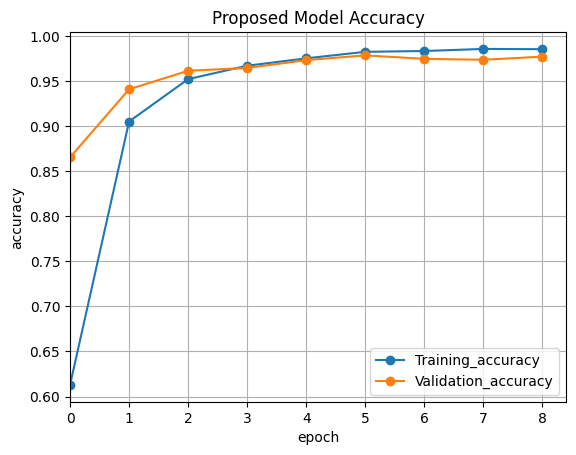

In [135]:
plt.plot(history_1.epoch, history_1.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('Proposed Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

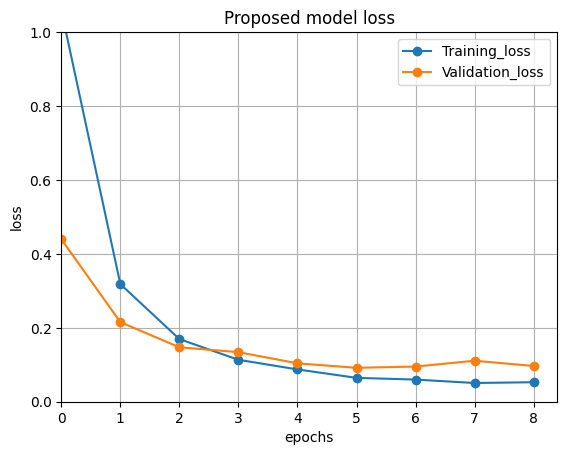

In [136]:
plt.plot(history_1.epoch, history_1.history['loss'], '-o', label='Training_loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Validation_loss')
plt.title('Proposed model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.close()

## CNN-BiLSTM MODEL

In [137]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'เอกสาร': 1, 'สอบถาม': 2, 'ค่า': 3, 'สวัสดี': 4, 'เทอม': 5, 'จบ': 6, 'วิชา': 7, 'จ่าย': 8, 'นักศึกษา': 9, '\r': 10, 'ทำ': 11, 'ใบ': 12, 'ไหม': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'เรื่อง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'ขึ้นทะเบียน': 21, 'ทราบ': 22, 'วันที่': 23, 'บัณฑิต': 24, 'ออนไลน์': 25, 'อะ': 26, 'ค่าชดเชย': 27, 'ตอนนี้': 28, 'กด': 29, 'เดี๋ยว': 30, 'ชำระ': 31, 'reg': 32, 'รอ': 33, 'ตอน': 34, 'คณะ': 35, 'ต้องการ': 36, '1': 37, '2': 38, 'ไห': 39, 'นิรันดร': 40, 'รบกวน': 41, 'เงิน': 42, 'citing': 43, 'รายวิชา': 44, 'รหัส': 45, 'ปี': 46, 'ติดต่อ': 47, 'ชำระเงิน': 48, 'เบิก': 49, 'ระบบ': 50, 'สักวัน': 51, 'การศึกษา': 52, '3': 53, 'gen': 54, 'มหาลัย': 55, 'เว็บ': 56, 'elisabeth': 57, 'จดทะเบียน': 58, 'พยาบาท': 59, 'กี่': 60, 'ฝังใจ': 61, 'ป': 62, 'แบบนี้': 63, 'เกรด': 64, 'โดยไม่รู้ตัว': 65, 'ตัว': 66, 'ล่าช้า': 67, 'อ่ะ': 68, 'ตรวจสอบ': 69, 'ขออนุญาต': 70, 'tu': 71, 'tar': 72, 'ชื่อ': 73, 'ค': 74, 'เลือก': 75, 'แคลคูลัส': 76, 'ดำเนินการ': 77, 'เรียบร้อย': 78, 'ขอบคุณ'

In [138]:
# # check the shape of each set
# print("X_train shape: {}".format(X_train.shape))
# print("y_train shape: {}".format(y_train.shape))

# # print("X_train_sub shape: {}".format(X_train_sub.shape))
# # print("y_train_sub shape: {}".format(y_train_sub.shape))

# # print("X_val shape: {}".format(X_val.shape))
# # print("y_val shape: {}".format(y_val.shape))

# print("X_test_unseen shape: {}".format(X_test_unseen.shape))
# print("y_test_unseen shape: {}".format(y_test_unseen.shape))

In [139]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test_unseen)))

Train set size = 13401 
Test set size = 4787


In [140]:
import tensorflow as tf

def build_model_2(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length)(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr_d),
        # optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "saved_model/best_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validate, y_validate),
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test_unseen, y_test_unseen) # or model.predict
    
    return model, history, train_time

In [141]:
# Train proposed model
model_2, history_5, train_time = build_model_2(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 61)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 61, 300)           1065600   
                                                                 
 spatial_dropout1d_35 (Spat  (None, 61, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_35 (Conv1D)          (None, 59, 50)            45050     
                                                                 
 max_pooling1d_35 (MaxPooli  (None, 29, 50)            0         
 ng1D)                                                           
                                                                 
 dropout_70 (Dropout)        (None, 29, 50)            0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/210 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.9299
Epoch 2: val_loss improved from 0.38294 to 0.17683, saving model to saved_model/best_CNN_BiLSTM_20240210_13-53-45.hdf5
210/210 [==============================] - 6s 30ms/step - loss: 0.2473 - accuracy: 0.9299 - val_loss: 0.1768 - val_accuracy: 0.9509
Epoch 3/10
209/210 [============================>.] - ETA: 0s - loss: 0.1225 - accuracy: 0.9674
Epoch 3: val_loss improved from 0.17683 to 0.12082, saving model to saved_model/best_CNN_BiLSTM_20240210_13-53-45.hdf5
210/210 [==============================] - 6s 30ms/step - loss: 0.1229 - accuracy: 0.9673 - val_loss: 0.1208 - val_accuracy: 0.9673
Epoch 4/10
209/210 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9776
Epoch 4: val_loss improved from 0.12082 to 0.09975, saving model to saved_model/best_CNN_BiLSTM_20240210_13-53-45.hdf5
210/210 [==============================] - 6s 30ms/step - loss: 0.0813 - accuracy: 0.9776 - val_loss: 

In [142]:
# Test 15%
predicted = model_2.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


90/90 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0     0.9735    0.9795    0.9765       975
           1     0.9704    0.9868    0.9785       531
           2     0.9921    0.9618    0.9767       131
           3     0.9744    0.9757    0.9751       701
           4     0.9254    0.9118    0.9185        68
           5     1.0000    0.9767    0.9882        86
           6     0.9838    0.9605    0.9720       380

    accuracy                         0.9749      2872
   macro avg     0.9742    0.9647    0.9694      2872
weighted avg     0.9750    0.9749    0.9749      2872

Testing Accuracy: 0.974930
Testing Precision: 0.975000
Testing Recall: 0.974930
Testing F1 score: 0.974915


In [143]:
df_results.loc['CNN-BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416


In [144]:
# Validate 15%
predicted_val = model_2.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

90/90 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     0.9806    0.9816    0.9811       976
           1     0.9650    0.9868    0.9758       531
           2     1.0000    0.9618    0.9805       131
           3     0.9802    0.9872    0.9837       701
           4     0.9692    0.9265    0.9474        68
           5     1.0000    0.9767    0.9882        86
           6     0.9892    0.9684    0.9787       380

    accuracy                         0.9798      2873
   macro avg     0.9835    0.9699    0.9765      2873
weighted avg     0.9799    0.9798    0.9798      2873

Testing Accuracy: 0.979812
Testing Precision: 0.979937
Testing Recall: 0.979812
Testing F1 score: 0.979802


In [145]:

df_results.loc['CNN-BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416
CNN-BiLSTM Validate 15%,0.979802,0.979937,0.979812,0.979812,60.656416


In [146]:
# Test unseen 15%

predicted = model_2.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

150/150 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0     0.9761    0.9809    0.9785      1626
           1     0.9592    0.9819    0.9704       885
           2     1.0000    0.9817    0.9908       219
           3     0.9811    0.9794    0.9803      1167
           4     0.9725    0.9381    0.9550       113
           5     0.9716    0.9514    0.9614       144
           6     0.9854    0.9605    0.9728       633

    accuracy                         0.9762      4787
   macro avg     0.9780    0.9677    0.9727      4787
weighted avg     0.9763    0.9762    0.9762      4787

Testing Accuracy: 0.976186
Testing Precision: 0.976307
Testing Recall: 0.976186
Testing F1 score: 0.976184


In [147]:

# append the results
df_results.loc['CNN-BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416
CNN-BiLSTM Validate 15%,0.979802,0.979937,0.979812,0.979812,60.656416
CNN-BiLSTM Test unseen 20%,0.976184,0.976307,0.976186,0.976186,60.656416


In [148]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'เอกสาร': 1, 'สอบถาม': 2, 'ค่า': 3, 'สวัสดี': 4, 'เทอม': 5, 'จบ': 6, 'วิชา': 7, 'จ่าย': 8, 'นักศึกษา': 9, '\r': 10, 'ทำ': 11, 'ใบ': 12, 'ไหม': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'เรื่อง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'ขึ้นทะเบียน': 21, 'ทราบ': 22, 'วันที่': 23, 'บัณฑิต': 24, 'ออนไลน์': 25, 'อะ': 26, 'ค่าชดเชย': 27, 'ตอนนี้': 28, 'กด': 29, 'เดี๋ยว': 30, 'ชำระ': 31, 'reg': 32, 'รอ': 33, 'ตอน': 34, 'คณะ': 35, 'ต้องการ': 36, '1': 37, '2': 38, 'ไห': 39, 'นิรันดร': 40, 'รบกวน': 41, 'เงิน': 42, 'citing': 43, 'รายวิชา': 44, 'รหัส': 45, 'ปี': 46, 'ติดต่อ': 47, 'ชำระเงิน': 48, 'เบิก': 49, 'ระบบ': 50, 'สักวัน': 51, 'การศึกษา': 52, '3': 53, 'gen': 54, 'มหาลัย': 55, 'เว็บ': 56, 'elisabeth': 57, 'จดทะเบียน': 58, 'พยาบาท': 59, 'กี่': 60, 'ฝังใจ': 61, 'ป': 62, 'แบบนี้': 63, 'เกรด': 64, 'โดยไม่รู้ตัว': 65, 'ตัว': 66, 'ล่าช้า': 67, 'อ่ะ': 68, 'ตรวจสอบ': 69, 'ขออนุญาต': 70, 'tu': 71, 'tar': 72, 'ชื่อ': 73, 'ค': 74, 'เลือก': 75, 'แคลคูลัส': 76, 'ดำเนินการ': 77, 'เรียบร้อย': 78, 'ขอบคุณ'

In [149]:

# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_cnn_bilstm = []
precision_scores_cnn_bilstm = []
f1_scores_cnn_bilstm = []
recall_scores_cnn_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time

# Perform cross-validation
fold_var = 1
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length)(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spa_dropout_ratio)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    cnn_bisltm_model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    cnn_bisltm_model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
        # optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT #################################
    check_point = ModelCheckpoint(cnn_bilstm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    
    # Display a summary of the models structure
    print(cnn_bisltm_model.summary())
    print("#"*80)
    # tf.keras.utils.plot_model(cnn_bisltm_model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = cnn_bisltm_model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
        callbacks=[check_point,early_stop])
    total_train_time += train_time
    
    y_pred=np.argmax(cnn_bisltm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_cnn_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_cnn_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))



------ Fold ---------- 2
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 61)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 61, 300)           1065600   
                                                                 
 spatial_dropout1d_36 (Spat  (None, 61, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_36 (Conv1D)          (None, 59, 50)            45050     
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 29, 50)            0         
 ng1D)                                                           
                                                                 
 dropout_72 (Dropout)        (Non

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/189 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.9008
Epoch 2: val_loss improved from 0.47317 to 0.21587, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.3321 - accuracy: 0.9008 - val_loss: 0.2159 - val_accuracy: 0.9471
Epoch 3/10
187/189 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9528
Epoch 3: val_loss improved from 0.21587 to 0.13129, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.1661 - accuracy: 0.9529 - val_loss: 0.1313 - val_accuracy: 0.9672
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9728
Epoch 4: val_loss improved from 0.13129 to 0.12603, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.0964 - accuracy: 0.9728 - val_loss: 0.1

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/189 [============================>.] - ETA: 0s - loss: 0.3286 - accuracy: 0.9051
Epoch 2: val_loss improved from 0.43936 to 0.22018, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.3275 - accuracy: 0.9055 - val_loss: 0.2202 - val_accuracy: 0.9328
Epoch 3/10
187/189 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9510
Epoch 3: val_loss improved from 0.22018 to 0.16395, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.1712 - accuracy: 0.9512 - val_loss: 0.1640 - val_accuracy: 0.9567
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9696
Epoch 4: val_loss improved from 0.16395 to 0.12192, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.1086 - accuracy: 0.9697 - val_loss: 0.1

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/189 [============================>.] - ETA: 0s - loss: 0.2776 - accuracy: 0.9237
Epoch 2: val_loss improved from 0.43416 to 0.21491, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 5s 29ms/step - loss: 0.2761 - accuracy: 0.9241 - val_loss: 0.2149 - val_accuracy: 0.9381
Epoch 3/10
187/189 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9588
Epoch 3: val_loss improved from 0.21491 to 0.17257, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 5s 29ms/step - loss: 0.1539 - accuracy: 0.9588 - val_loss: 0.1726 - val_accuracy: 0.9500
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9708
Epoch 4: val_loss improved from 0.17257 to 0.12884, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 5s 29ms/step - loss: 0.1091 - accuracy: 0.9706 - val_loss: 0.1

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/189 [============================>.] - ETA: 0s - loss: 0.3278 - accuracy: 0.9029
Epoch 2: val_loss improved from 0.49240 to 0.28064, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 29ms/step - loss: 0.3272 - accuracy: 0.9032 - val_loss: 0.2806 - val_accuracy: 0.9216
Epoch 3/10
187/189 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9536
Epoch 3: val_loss improved from 0.28064 to 0.17593, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 29ms/step - loss: 0.1666 - accuracy: 0.9537 - val_loss: 0.1759 - val_accuracy: 0.9478
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9670
Epoch 4: val_loss improved from 0.17593 to 0.15003, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 29ms/step - loss: 0.1144 - accuracy: 0.9671 - val_loss: 0.1

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/189 [============================>.] - ETA: 0s - loss: 0.3314 - accuracy: 0.9037
Epoch 2: val_loss improved from 0.46926 to 0.22808, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.3316 - accuracy: 0.9036 - val_loss: 0.2281 - val_accuracy: 0.9410
Epoch 3/10
187/189 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9577
Epoch 3: val_loss improved from 0.22808 to 0.15242, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.1612 - accuracy: 0.9575 - val_loss: 0.1524 - val_accuracy: 0.9619
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9724
Epoch 4: val_loss improved from 0.15242 to 0.12962, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 6s 30ms/step - loss: 0.1049 - accuracy: 0.9724 - val_loss: 0.1

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/189 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.9163
Epoch 2: val_loss improved from 0.39714 to 0.16332, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 69ms/step - loss: 0.2932 - accuracy: 0.9164 - val_loss: 0.1633 - val_accuracy: 0.9463
Epoch 3/10
188/189 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9603
Epoch 3: val_loss improved from 0.16332 to 0.11571, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 66ms/step - loss: 0.1481 - accuracy: 0.9604 - val_loss: 0.1157 - val_accuracy: 0.9657
Epoch 4/10
188/189 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9699
Epoch 4: val_loss improved from 0.11571 to 0.08802, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 12s 66ms/step - loss: 0.1100 - accuracy: 0.9699 - val_loss: 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/189 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.9059
Epoch 2: val_loss improved from 0.45528 to 0.27251, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 67ms/step - loss: 0.3229 - accuracy: 0.9058 - val_loss: 0.2725 - val_accuracy: 0.9328
Epoch 3/10
188/189 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9529
Epoch 3: val_loss improved from 0.27251 to 0.20527, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 67ms/step - loss: 0.1753 - accuracy: 0.9529 - val_loss: 0.2053 - val_accuracy: 0.9478
Epoch 4/10
188/189 [============================>.] - ETA: 0s - loss: 0.1175 - accuracy: 0.9672
Epoch 4: val_loss improved from 0.20527 to 0.16716, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 66ms/step - loss: 0.1176 - accuracy: 0.9670 - val_loss: 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/189 [============================>.] - ETA: 0s - loss: 0.3415 - accuracy: 0.8959
Epoch 2: val_loss improved from 0.44300 to 0.25357, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 69ms/step - loss: 0.3412 - accuracy: 0.8959 - val_loss: 0.2536 - val_accuracy: 0.9306
Epoch 3/10
188/189 [============================>.] - ETA: 0s - loss: 0.1790 - accuracy: 0.9500
Epoch 3: val_loss improved from 0.25357 to 0.17010, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 68ms/step - loss: 0.1786 - accuracy: 0.9501 - val_loss: 0.1701 - val_accuracy: 0.9567
Epoch 4/10
188/189 [============================>.] - ETA: 0s - loss: 0.1133 - accuracy: 0.9681
Epoch 4: val_loss improved from 0.17010 to 0.15761, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 68ms/step - loss: 0.1131 - accuracy: 0.9682 - val_loss: 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/189 [============================>.] - ETA: 0s - loss: 0.3497 - accuracy: 0.8950
Epoch 2: val_loss improved from 0.50150 to 0.28580, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 67ms/step - loss: 0.3500 - accuracy: 0.8950 - val_loss: 0.2858 - val_accuracy: 0.9209
Epoch 3/10
188/189 [============================>.] - ETA: 0s - loss: 0.2012 - accuracy: 0.9433
Epoch 3: val_loss improved from 0.28580 to 0.17715, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 69ms/step - loss: 0.2011 - accuracy: 0.9433 - val_loss: 0.1771 - val_accuracy: 0.9530
Epoch 4/10
188/189 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9630
Epoch 4: val_loss improved from 0.17715 to 0.15062, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 69ms/step - loss: 0.1404 - accuracy: 0.9628 - val_loss: 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/189 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.9098
Epoch 2: val_loss improved from 0.47115 to 0.23379, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 70ms/step - loss: 0.3039 - accuracy: 0.9100 - val_loss: 0.2338 - val_accuracy: 0.9336
Epoch 3/10
188/189 [============================>.] - ETA: 0s - loss: 0.1510 - accuracy: 0.9582
Epoch 3: val_loss improved from 0.23379 to 0.17136, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 71ms/step - loss: 0.1510 - accuracy: 0.9582 - val_loss: 0.1714 - val_accuracy: 0.9552
Epoch 4/10
188/189 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9716
Epoch 4: val_loss improved from 0.17136 to 0.13297, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
189/189 [==============================] - 13s 69ms/step - loss: 0.0986 - accuracy: 0.9716 - val_loss: 

In [150]:
accuracy_avg_cnn_bilstm = sum(accuracy_scores_cnn_bilstm) / len(accuracy_scores_cnn_bilstm)
precision_avg_cnn_bilstm = sum(precision_scores_cnn_bilstm) / len(precision_scores_cnn_bilstm)
recall_avg_cnn_bilstm = sum(recall_scores_cnn_bilstm) / len(recall_scores_cnn_bilstm)
f1_avg_cnn_bilstm = sum(f1_scores_cnn_bilstm) / len(f1_scores_cnn_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_cnn_bilstm,
    'Precision': precision_scores_cnn_bilstm,
    'Recall': recall_scores_cnn_bilstm,
    'F1 Score': f1_scores_cnn_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_cnn_bilstm,precision_avg_cnn_bilstm,recall_avg_cnn_bilstm,f1_avg_cnn_bilstm]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.974646 |    0.97484  | 0.97463  |   0.97463  |
| 2      |   0.973134 |    0.973305 | 0.973151 |   0.973151 |
| 3      |   0.968657 |    0.969048 | 0.96869  |   0.96869  |
| 4      |   0.970149 |    0.970278 | 0.970157 |   0.970157 |
| 5      |   0.970896 |    0.971806 | 0.971097 |   0.971097 |
| 6      |   0.973881 |    0.974073 | 0.973896 |   0.973896 |
| 7      |   0.970896 |    0.971445 | 0.970993 |   0.970993 |
| 8      |   0.974627 |    0.975698 | 0.974859 |   0.974859 |
| 9      |   0.971642 |    0.971758 | 0.971605 |   0.971605 |
| 10     |   0.975373 |    0.975471 | 0.975355 |   0.975355 |
| Avg.   |   0.97239  |    0.972772 | 0.972443 |   0.972443 |


In [151]:
df_results_cross_val.loc['CNN-BiLSTM avg cross validation data train 80%'] = [f1_avg_cnn_bilstm, precision_avg_cnn_bilstm, recall_avg_cnn_bilstm, accuracy_avg_cnn_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.972387,0.972610,0.972387,0.972390,789.397488
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.972565,0.972851,0.972634,0.972634,78.939749
CNN-BiLSTM avg cross validation data train 80%,0.972443,0.972772,0.972443,0.972390,606.564159


In [154]:
# Test cross validation 20%
model_bilstm_cross_validate = load_model(cnn_bilstm_cross_validate_model_path)
predicted = model_bilstm_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

150/150 [==============================] - 1s 4ms/step
Testing Accuracy: 0.976603
Testing Precision: 0.976754
Testing Recall: 0.976603
Testing F1 score: 0.976594


In [155]:
df_results_cross_val.loc['CNN-BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.972387,0.972610,0.972387,0.972390,789.397488
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.972565,0.972851,0.972634,0.972634,78.939749
CNN-BiLSTM avg cross validation data train 80%,0.972443,0.972772,0.972443,0.972390,606.564159
CNN-BiLSTM avg cross validation data test 20%,0.976594,0.976754,0.976603,0.976603,60.656416


### Plotting the results

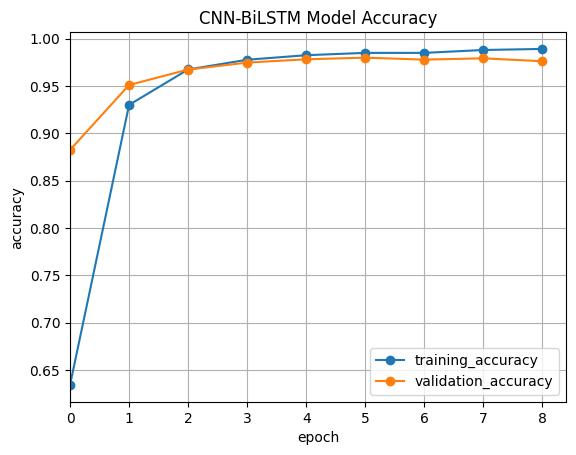

In [156]:
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


plt.plot(history_5.epoch, history_5.history['accuracy'], '-o', label='training_accuracy')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='validation_accuracy')
plt.title('CNN-BiLSTM Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

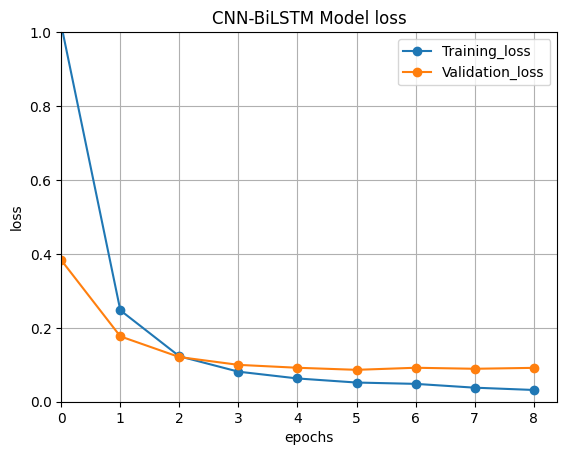

In [157]:
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history_5.epoch, history_5.history['loss'], '-o', label='Training_loss')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='Validation_loss')
plt.title('CNN-BiLSTM Model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# BASELINES MODELS

## 1D CNN MODEL

In [158]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

# ### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'เอกสาร': 1, 'สอบถาม': 2, 'ค่า': 3, 'สวัสดี': 4, 'เทอม': 5, 'จบ': 6, 'วิชา': 7, 'จ่าย': 8, 'นักศึกษา': 9, '\r': 10, 'ทำ': 11, 'ใบ': 12, 'ไหม': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'เรื่อง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'ขึ้นทะเบียน': 21, 'ทราบ': 22, 'วันที่': 23, 'บัณฑิต': 24, 'ออนไลน์': 25, 'อะ': 26, 'ค่าชดเชย': 27, 'ตอนนี้': 28, 'กด': 29, 'เดี๋ยว': 30, 'ชำระ': 31, 'reg': 32, 'รอ': 33, 'ตอน': 34, 'คณะ': 35, 'ต้องการ': 36, '1': 37, '2': 38, 'ไห': 39, 'นิรันดร': 40, 'รบกวน': 41, 'เงิน': 42, 'citing': 43, 'รายวิชา': 44, 'รหัส': 45, 'ปี': 46, 'ติดต่อ': 47, 'ชำระเงิน': 48, 'เบิก': 49, 'ระบบ': 50, 'สักวัน': 51, 'การศึกษา': 52, '3': 53, 'gen': 54, 'มหาลัย': 55, 'เว็บ': 56, 'elisabeth': 57, 'จดทะเบียน': 58, 'พยาบาท': 59, 'กี่': 60, 'ฝังใจ': 61, 'ป': 62, 'แบบนี้': 63, 'เกรด': 64, 'โดยไม่รู้ตัว': 65, 'ตัว': 66, 'ล่าช้า': 67, 'อ่ะ': 68, 'ตรวจสอบ': 69, 'ขออนุญาต': 70, 'tu': 71, 'tar': 72, 'ชื่อ': 73, 'ค': 74, 'เลือก': 75, 'แคลคูลัส': 76, 'ดำเนินการ': 77, 'เรียบร้อย': 78, 'ขอบคุณ'

In [159]:

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test_unseen shape: {}".format(X_test_unseen.shape))
print("y_test_unseen shape: {}".format(y_test_unseen.shape))

X_train shape: (13401, 61)
y_train shape: (13401, 7)
X_test_unseen shape: (4787, 61)
y_test_unseen shape: (4787, 7)


In [160]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 13401 
Test set size = 2872


In [161]:
#Model Definition
model_3 = Sequential()
model_3.add(Embedding(MAX_NB_WORDS, embed_dim,input_length=max_length))
# model.add(Dropout(0.25))
model_3.add(SpatialDropout1D(spa_dropout_ratio))

model_3.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
model_3.add(Dense(dense_units, activation='relu'))
model_3.add(Flatten()) # no need if used Global poooling
model_3.add(Dropout(dropout_ratio))

model_3.add(Dense(7, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))
######################## COMPILING THE MODEL ##################################
model_3.compile(
    loss = "categorical_crossentropy", 
   optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
    metrics = [
        "accuracy",
#       "binary_accuracy",
        'categorical_accuracy',
#       tf.keras.metrics.AUC(),
#       tf.keras.metrics.Precision(),
#       tf.keras.metrics.Recall()
        ]
    )

print(model_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 61, 300)           1065600   
                                                                 
 spatial_dropout1d_46 (Spat  (None, 61, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_46 (Conv1D)          (None, 59, 50)            45050     
                                                                 
 max_pooling1d_46 (MaxPooli  (None, 29, 50)            0         
 ng1D)                                                           
                                                                 
 dense_92 (Dense)            (None, 29, 64)            3264      
                                                                 
 flatten (Flatten)           (None, 1856)              0

In [162]:
checkpoint = ModelCheckpoint("saved_model/"+"1D_CNN_"+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint, earlystopping]

# fit network
start_time = time()
history_2 = model_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_data=(X_validate, y_validate))
train_time = time() - start_time
print(train_time)

Epoch 1/10
210/210 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 0.7146 - categorical_accuracy: 0.7146
Epoch 1: loss improved from inf to 0.84900, saving model to saved_model/1D_CNN_20240210_14:22:39.h5
210/210 [==============================] - 2s 10ms/step - loss: 0.8490 - accuracy: 0.7146 - categorical_accuracy: 0.7146 - val_loss: 0.3244 - val_accuracy: 0.8987 - val_categorical_accuracy: 0.8987
Epoch 2/10
 17/210 [=>............................] - ETA: 1s - loss: 0.3101 - accuracy: 0.9072 - categorical_accuracy: 0.9072

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/210 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9386 - categorical_accuracy: 0.9386
Epoch 2: loss improved from 0.84900 to 0.20182, saving model to saved_model/1D_CNN_20240210_14:22:39.h5
210/210 [==============================] - 4s 20ms/step - loss: 0.2018 - accuracy: 0.9386 - categorical_accuracy: 0.9386 - val_loss: 0.1467 - val_accuracy: 0.9624 - val_categorical_accuracy: 0.9624
Epoch 3/10
209/210 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9775 - categorical_accuracy: 0.9775
Epoch 3: loss improved from 0.20182 to 0.08011, saving model to saved_model/1D_CNN_20240210_14:22:39.h5
210/210 [==============================] - 11s 54ms/step - loss: 0.0801 - accuracy: 0.9775 - categorical_accuracy: 0.9775 - val_loss: 0.0965 - val_accuracy: 0.9777 - val_categorical_accuracy: 0.9777
Epoch 4/10
209/210 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9865 - categorical_accuracy: 0.9865
Epoch 4: loss improved fr

In [163]:
# Test 15%
predicted = model_3.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

90/90 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0     0.9776    0.9826    0.9801       975
           1     0.9848    0.9793    0.9821       531
           2     0.9846    0.9771    0.9808       131
           3     0.9679    0.9900    0.9788       701
           4     1.0000    0.9265    0.9618        68
           5     0.9880    0.9535    0.9704        86
           6     0.9892    0.9658    0.9774       380

    accuracy                         0.9791      2872
   macro avg     0.9846    0.9678    0.9759      2872
weighted avg     0.9793    0.9791    0.9791      2872

Testing Accuracy: 0.979109
Testing Precision: 0.979259
Testing Recall: 0.979109
Testing F1 score: 0.979088


In [164]:

df_results.loc['1D_CNN Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416
CNN-BiLSTM Validate 15%,0.979802,0.979937,0.979812,0.979812,60.656416
CNN-BiLSTM Test unseen 20%,0.976184,0.976307,0.976186,0.976186,60.656416
1D_CNN Test 15%,0.979088,0.979259,0.979109,0.979109,120.245527


In [165]:
# append the results

predicted = model_3.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)



150/150 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0     0.9809    0.9809    0.9809      1626
           1     0.9828    0.9706    0.9767       885
           2     0.9908    0.9817    0.9862       219
           3     0.9666    0.9906    0.9784      1167
           4     0.9905    0.9204    0.9541       113
           5     1.0000    0.9583    0.9787       144
           6     0.9715    0.9684    0.9699       633

    accuracy                         0.9776      4787
   macro avg     0.9833    0.9673    0.9750      4787
weighted avg     0.9778    0.9776    0.9776      4787

Testing Accuracy: 0.977648
Testing Precision: 0.977779
Testing Recall: 0.977648
Testing F1 score: 0.977626


In [166]:
df_results.loc['1D_CNN Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416
CNN-BiLSTM Validate 15%,0.979802,0.979937,0.979812,0.979812,60.656416
CNN-BiLSTM Test unseen 20%,0.976184,0.976307,0.976186,0.976186,60.656416
1D_CNN Test 15%,0.979088,0.979259,0.979109,0.979109,120.245527
1D_CNN Test unseen 20%,0.977626,0.977779,0.977648,0.977648,120.245527


In [167]:
# Validate 15%
predicted_val = model_3.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)


90/90 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0     0.9826    0.9846    0.9836       976
           1     0.9772    0.9699    0.9735       531
           2     0.9922    0.9695    0.9807       131
           3     0.9680    0.9929    0.9803       701
           4     0.9846    0.9412    0.9624        68
           5     1.0000    0.9651    0.9822        86
           6     0.9893    0.9711    0.9801       380

    accuracy                         0.9798      2873
   macro avg     0.9848    0.9706    0.9776      2873
weighted avg     0.9799    0.9798    0.9798      2873

Testing Accuracy: 0.979812
Testing Precision: 0.979943
Testing Recall: 0.979812
Testing F1 score: 0.979798


In [168]:
df_results.loc['1D_CNN Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416
CNN-BiLSTM Validate 15%,0.979802,0.979937,0.979812,0.979812,60.656416
CNN-BiLSTM Test unseen 20%,0.976184,0.976307,0.976186,0.976186,60.656416
1D_CNN Test 15%,0.979088,0.979259,0.979109,0.979109,120.245527
1D_CNN Test unseen 20%,0.977626,0.977779,0.977648,0.977648,120.245527
1D_CNN Validate 15%,0.979798,0.979943,0.979812,0.979812,120.245527


In [169]:
# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_1d_cnn = []
precision_scores_1d_cnn = []
f1_scores_1d_cnn = []
recall_scores_1d_cnn = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation
fold_var = 1
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    #Model Definition
    cnn_model = Sequential()
    cnn_model.add(Embedding(MAX_NB_WORDS, embed_dim,input_length=max_length))
    # model.add(Dropout(0.25))
    cnn_model.add(SpatialDropout1D(spa_dropout_ratio))

    cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    # model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(dense_units, activation='relu'))
    cnn_model.add(Flatten()) # no need if used Global poooling
    cnn_model.add(Dropout(dropout_ratio))

    cnn_model.add(Dense(7, activation='softmax'))
    # model.add(Dense(1, activation='sigmoid'))
    ######################## COMPILING THE MODEL ##################################
    cnn_model.compile(
        loss = "categorical_crossentropy", 
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
    #         optimizer='adam',
        metrics = [
            "accuracy",
    #       "binary_accuracy",
            'categorical_accuracy',
    #       tf.keras.metrics.AUC(),
    #       tf.keras.metrics.Precision(),
    #       tf.keras.metrics.Recall()
            ]
        )
    
   
    check_point = ModelCheckpoint(cnn_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = cnn_model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
        callbacks=[check_point,early_stop])
    total_train_time += train_time  
    
    y_pred=np.argmax(cnn_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_1d_cnn.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_1d_cnn.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_1d_cnn.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_1d_cnn.append(f1_score(y_true_validation_test, y_pred, average='weighted'))


------ Fold ---------- 2
Epoch 1/10
188/189 [============================>.] - ETA: 0s - loss: 0.9408 - accuracy: 0.6752 - categorical_accuracy: 0.6752
Epoch 1: val_loss improved from inf to 0.36388, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 14s 68ms/step - loss: 0.9394 - accuracy: 0.6756 - categorical_accuracy: 0.6756 - val_loss: 0.3639 - val_accuracy: 0.8956 - val_categorical_accuracy: 0.8956
Epoch 2/10
  2/189 [..............................] - ETA: 10s - loss: 0.3992 - accuracy: 0.8906 - categorical_accuracy: 0.8906

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/189 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9337 - categorical_accuracy: 0.9337
Epoch 2: val_loss improved from 0.36388 to 0.15364, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 13s 68ms/step - loss: 0.2264 - accuracy: 0.9337 - categorical_accuracy: 0.9337 - val_loss: 0.1536 - val_accuracy: 0.9590 - val_categorical_accuracy: 0.9590
Epoch 3/10
189/189 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9768 - categorical_accuracy: 0.9768
Epoch 3: val_loss improved from 0.15364 to 0.10050, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 12s 66ms/step - loss: 0.0877 - accuracy: 0.9768 - categorical_accuracy: 0.9768 - val_loss: 0.1005 - val_accuracy: 0.9732 - val_categorical_accuracy: 0.9732
Epoch 4/10
189/189 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9864 - categorical_accuracy: 0.9864
Epoch 4: v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/189 [============================>.] - ETA: 0s - loss: 0.2123 - accuracy: 0.9397 - categorical_accuracy: 0.9397
Epoch 2: val_loss improved from 0.35897 to 0.13245, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 12ms/step - loss: 0.2114 - accuracy: 0.9399 - categorical_accuracy: 0.9399 - val_loss: 0.1325 - val_accuracy: 0.9597 - val_categorical_accuracy: 0.9597
Epoch 3/10
188/189 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9738 - categorical_accuracy: 0.9738
Epoch 3: val_loss improved from 0.13245 to 0.07681, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 12ms/step - loss: 0.0873 - accuracy: 0.9738 - categorical_accuracy: 0.9738 - val_loss: 0.0768 - val_accuracy: 0.9791 - val_categorical_accuracy: 0.9791
Epoch 4/10
186/189 [============================>.] - ETA: 0s - loss: 0.0494 - accuracy: 0.9850 - categorical_accuracy: 0.9850
Epoch 4: val

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


183/189 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9358 - categorical_accuracy: 0.9358
Epoch 2: val_loss improved from 0.38660 to 0.15458, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 9ms/step - loss: 0.2271 - accuracy: 0.9366 - categorical_accuracy: 0.9366 - val_loss: 0.1546 - val_accuracy: 0.9500 - val_categorical_accuracy: 0.9500
Epoch 3/10
185/189 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9739 - categorical_accuracy: 0.9739
Epoch 3: val_loss improved from 0.15458 to 0.11382, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 9ms/step - loss: 0.0909 - accuracy: 0.9739 - categorical_accuracy: 0.9739 - val_loss: 0.1138 - val_accuracy: 0.9649 - val_categorical_accuracy: 0.9649
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.0482 - accuracy: 0.9872 - categorical_accuracy: 0.9872
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/189 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9382 - categorical_accuracy: 0.9382
Epoch 2: val_loss improved from 0.37291 to 0.17778, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 9ms/step - loss: 0.2116 - accuracy: 0.9386 - categorical_accuracy: 0.9386 - val_loss: 0.1778 - val_accuracy: 0.9493 - val_categorical_accuracy: 0.9493
Epoch 3/10
183/189 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9746 - categorical_accuracy: 0.9746
Epoch 3: val_loss improved from 0.17778 to 0.12355, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 9ms/step - loss: 0.0881 - accuracy: 0.9750 - categorical_accuracy: 0.9750 - val_loss: 0.1235 - val_accuracy: 0.9649 - val_categorical_accuracy: 0.9649
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9849 - categorical_accuracy: 0.9849
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/189 [============================>.] - ETA: 0s - loss: 0.2127 - accuracy: 0.9369 - categorical_accuracy: 0.9369
Epoch 2: val_loss improved from 0.34829 to 0.13749, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 9ms/step - loss: 0.2122 - accuracy: 0.9372 - categorical_accuracy: 0.9372 - val_loss: 0.1375 - val_accuracy: 0.9627 - val_categorical_accuracy: 0.9627
Epoch 3/10
188/189 [============================>.] - ETA: 0s - loss: 0.0881 - accuracy: 0.9747 - categorical_accuracy: 0.9747
Epoch 3: val_loss improved from 0.13749 to 0.10581, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 9ms/step - loss: 0.0882 - accuracy: 0.9746 - categorical_accuracy: 0.9746 - val_loss: 0.1058 - val_accuracy: 0.9694 - val_categorical_accuracy: 0.9694
Epoch 4/10
189/189 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9858 - categorical_accuracy: 0.9858
Epoch 4: val_l

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/189 [============================>.] - ETA: 0s - loss: 0.1980 - accuracy: 0.9428 - categorical_accuracy: 0.9428
Epoch 2: val_loss improved from 0.33202 to 0.10850, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 10ms/step - loss: 0.1973 - accuracy: 0.9430 - categorical_accuracy: 0.9430 - val_loss: 0.1085 - val_accuracy: 0.9709 - val_categorical_accuracy: 0.9709
Epoch 3/10
185/189 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9776 - categorical_accuracy: 0.9776
Epoch 3: val_loss improved from 0.10850 to 0.07505, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 10ms/step - loss: 0.0802 - accuracy: 0.9778 - categorical_accuracy: 0.9778 - val_loss: 0.0751 - val_accuracy: 0.9754 - val_categorical_accuracy: 0.9754
Epoch 4/10
189/189 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9900 - categorical_accuracy: 0.9900
Epoch 4: val

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/189 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9375 - categorical_accuracy: 0.9375
Epoch 2: val_loss improved from 0.36966 to 0.15832, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 10ms/step - loss: 0.2130 - accuracy: 0.9374 - categorical_accuracy: 0.9374 - val_loss: 0.1583 - val_accuracy: 0.9552 - val_categorical_accuracy: 0.9552
Epoch 3/10
187/189 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9742 - categorical_accuracy: 0.9742
Epoch 3: val_loss improved from 0.15832 to 0.11008, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 9ms/step - loss: 0.0949 - accuracy: 0.9743 - categorical_accuracy: 0.9743 - val_loss: 0.1101 - val_accuracy: 0.9701 - val_categorical_accuracy: 0.9701
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9850 - categorical_accuracy: 0.9850
Epoch 4: val_

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/189 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9294 - categorical_accuracy: 0.9294
Epoch 2: val_loss improved from 0.35710 to 0.18216, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 10ms/step - loss: 0.2363 - accuracy: 0.9293 - categorical_accuracy: 0.9293 - val_loss: 0.1822 - val_accuracy: 0.9530 - val_categorical_accuracy: 0.9530
Epoch 3/10
185/189 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.9717 - categorical_accuracy: 0.9717
Epoch 3: val_loss improved from 0.18216 to 0.12430, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 10ms/step - loss: 0.1055 - accuracy: 0.9716 - categorical_accuracy: 0.9716 - val_loss: 0.1243 - val_accuracy: 0.9687 - val_categorical_accuracy: 0.9687
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.0606 - accuracy: 0.9830 - categorical_accuracy: 0.9830
Epoch 4: val

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/189 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9284 - categorical_accuracy: 0.9284
Epoch 2: val_loss improved from 0.39188 to 0.16767, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 10ms/step - loss: 0.2441 - accuracy: 0.9287 - categorical_accuracy: 0.9287 - val_loss: 0.1677 - val_accuracy: 0.9515 - val_categorical_accuracy: 0.9515
Epoch 3/10
187/189 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9722 - categorical_accuracy: 0.9722
Epoch 3: val_loss improved from 0.16767 to 0.11892, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 10ms/step - loss: 0.0995 - accuracy: 0.9721 - categorical_accuracy: 0.9721 - val_loss: 0.1189 - val_accuracy: 0.9694 - val_categorical_accuracy: 0.9694
Epoch 4/10
185/189 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9866 - categorical_accuracy: 0.9866
Epoch 4: val

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/189 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9419 - categorical_accuracy: 0.9419
Epoch 2: val_loss improved from 0.40958 to 0.15423, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 9ms/step - loss: 0.2063 - accuracy: 0.9427 - categorical_accuracy: 0.9427 - val_loss: 0.1542 - val_accuracy: 0.9619 - val_categorical_accuracy: 0.9619
Epoch 3/10
185/189 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9781 - categorical_accuracy: 0.9781
Epoch 3: val_loss improved from 0.15423 to 0.11144, saving model to saved_model/best_CNN_Cross_validation.hdf5
189/189 [==============================] - 2s 10ms/step - loss: 0.0809 - accuracy: 0.9784 - categorical_accuracy: 0.9784 - val_loss: 0.1114 - val_accuracy: 0.9679 - val_categorical_accuracy: 0.9679
Epoch 4/10
187/189 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9865 - categorical_accuracy: 0.9865
Epoch 4: val_

In [170]:
accuracy_avg_1d_cnn = sum(accuracy_scores_1d_cnn) / len(accuracy_scores_1d_cnn)
precision_avg_1d_cnn = sum(precision_scores_1d_cnn) / len(precision_scores_1d_cnn)
recall_avg_1d_cnn = sum(recall_scores_1d_cnn) / len(recall_scores_1d_cnn)
f1_avg_1d_cnn = sum(f1_scores_1d_cnn) / len(f1_scores_1d_cnn)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_1d_cnn,
    'Precision': precision_scores_1d_cnn,
    'Recall': recall_scores_1d_cnn,
    'F1 Score': f1_scores_1d_cnn
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_1d_cnn,precision_avg_1d_cnn,recall_avg_1d_cnn,f1_avg_1d_cnn]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.979866 |    0.979999 | 0.979819 |   0.979819 |
| 2      |   0.979851 |    0.979962 | 0.97985  |   0.97985  |
| 3      |   0.972388 |    0.972647 | 0.972429 |   0.972429 |
| 4      |   0.970896 |    0.970941 | 0.970876 |   0.970876 |
| 5      |   0.976119 |    0.976319 | 0.976074 |   0.976074 |
| 6      |   0.973881 |    0.973921 | 0.973818 |   0.973818 |
| 7      |   0.967164 |    0.967342 | 0.9671   |   0.9671   |
| 8      |   0.979851 |    0.979947 | 0.97982  |   0.97982  |
| 9      |   0.973134 |    0.97321  | 0.973154 |   0.973154 |
| 10     |   0.976866 |    0.977004 | 0.976872 |   0.976872 |
| Avg.   |   0.975002 |    0.975129 | 0.974981 |   0.974981 |


In [171]:
df_results_cross_val.loc['1D_CNN avg cross validation data test 80%'] = [f1_avg_1d_cnn, precision_avg_1d_cnn, recall_avg_1d_cnn, accuracy_avg_1d_cnn, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.972387,0.972610,0.972387,0.972390,789.397488
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.972565,0.972851,0.972634,0.972634,78.939749
CNN-BiLSTM avg cross validation data train 80%,0.972443,0.972772,0.972443,0.972390,606.564159
CNN-BiLSTM avg cross validation data test 20%,0.976594,0.976754,0.976603,0.976603,60.656416
1D_CNN avg cross validation data test 80%,0.974981,0.975129,0.974981,0.975002,1202.455268


In [173]:
# Test cross validation 20%
model_cnn_cross_validate = load_model(cnn_cross_validate_model_path)
predicted = model_cnn_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
# y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

150/150 [==============================] - 0s 2ms/step
Testing Accuracy: 0.977857
Testing Precision: 0.977994
Testing Recall: 0.977857
Testing F1 score: 0.977870


In [174]:
df_results_cross_val.loc['1D_CNN avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.972387,0.972610,0.972387,0.972390,789.397488
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.972565,0.972851,0.972634,0.972634,78.939749
CNN-BiLSTM avg cross validation data train 80%,0.972443,0.972772,0.972443,0.972390,606.564159
CNN-BiLSTM avg cross validation data test 20%,0.976594,0.976754,0.976603,0.976603,60.656416
1D_CNN avg cross validation data test 80%,0.974981,0.975129,0.974981,0.975002,1202.455268
1D_CNN avg cross validation data test 20%,0.977870,0.977994,0.977857,0.977857,120.245527


### **Plotting the results**

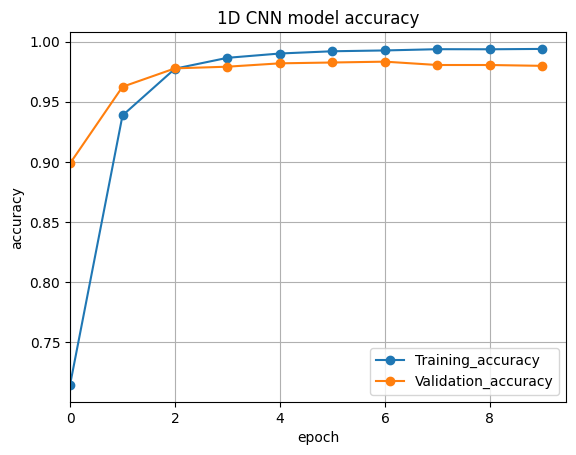

In [175]:
plt.plot(history_2.epoch, history_2.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('1D CNN model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

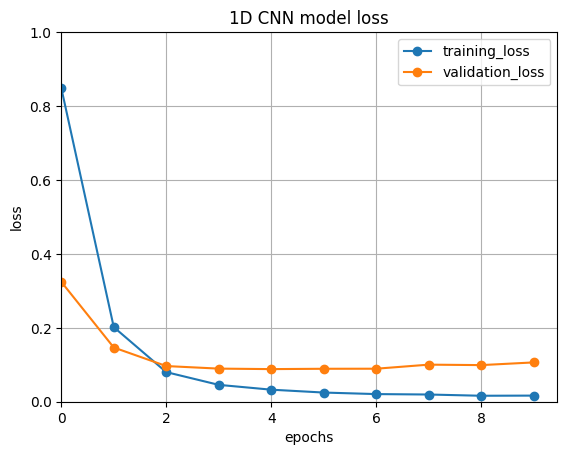

In [176]:
plt.plot(history_2.epoch, history_2.history['loss'], '-o', label='training_loss')
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.title('1D CNN model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

## BiLSTM MODEL

In [177]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'เอกสาร': 1, 'สอบถาม': 2, 'ค่า': 3, 'สวัสดี': 4, 'เทอม': 5, 'จบ': 6, 'วิชา': 7, 'จ่าย': 8, 'นักศึกษา': 9, '\r': 10, 'ทำ': 11, 'ใบ': 12, 'ไหม': 13, 'หนู': 14, 'แจ้ง': 15, 'ผม': 16, 'เรื่อง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'ขึ้นทะเบียน': 21, 'ทราบ': 22, 'วันที่': 23, 'บัณฑิต': 24, 'ออนไลน์': 25, 'อะ': 26, 'ค่าชดเชย': 27, 'ตอนนี้': 28, 'กด': 29, 'เดี๋ยว': 30, 'ชำระ': 31, 'reg': 32, 'รอ': 33, 'ตอน': 34, 'คณะ': 35, 'ต้องการ': 36, '1': 37, '2': 38, 'ไห': 39, 'นิรันดร': 40, 'รบกวน': 41, 'เงิน': 42, 'citing': 43, 'รายวิชา': 44, 'รหัส': 45, 'ปี': 46, 'ติดต่อ': 47, 'ชำระเงิน': 48, 'เบิก': 49, 'ระบบ': 50, 'สักวัน': 51, 'การศึกษา': 52, '3': 53, 'gen': 54, 'มหาลัย': 55, 'เว็บ': 56, 'elisabeth': 57, 'จดทะเบียน': 58, 'พยาบาท': 59, 'กี่': 60, 'ฝังใจ': 61, 'ป': 62, 'แบบนี้': 63, 'เกรด': 64, 'โดยไม่รู้ตัว': 65, 'ตัว': 66, 'ล่าช้า': 67, 'อ่ะ': 68, 'ตรวจสอบ': 69, 'ขออนุญาต': 70, 'tu': 71, 'tar': 72, 'ชื่อ': 73, 'ค': 74, 'เลือก': 75, 'แคลคูลัส': 76, 'ดำเนินการ': 77, 'เรียบร้อย': 78, 'ขอบคุณ'

In [178]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test_unseen)))

Train set size = 13401 
Test set size = 4787


In [179]:
#Model Definition
model_4 = Sequential()
model_4.add(Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length))
# model.add(Dropout(0.25))
model_4.add(SpatialDropout1D(spa_dropout_ratio))

# model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(hidden_units, activation='relu'))
# model.add(Dropout(dropout_ratio))

model_4.add(Bidirectional(LSTM(lstm_units_1,return_sequences=True)))
# model.add(Dropout(dropout_ratio))
model_4.add(Bidirectional(LSTM(lstm_units_2)))
model_4.add(Dense(dense_units, activation='relu'))
model_4.add(Dropout(dropout_ratio))

model_4.add(Dense(7, activation='softmax'))
    
######################## COMPILING THE MODEL ##################################
model_4.compile(
    loss = "categorical_crossentropy", 
     optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
    metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )

print(model_4.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 61, 300)           1065600   
                                                                 
 spatial_dropout1d_57 (Spat  (None, 61, 300)           0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_92 (Bidirect  (None, 61, 128)           186880    
 ional)                                                          
                                                                 
 bidirectional_93 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_114 (Dense)           (None, 64)                4160      
                                                     

In [180]:
checkpoint = ModelCheckpoint("saved_model/"+"BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint,earlystopping]

# fit network
start_time = time()
history_4 = model_4.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_data=(X_validate, y_validate))
train_time = time() - start_time
print(train_time)

Epoch 1/10
209/210 [============================>.] - ETA: 0s - loss: 0.8749 - accuracy: 0.7021 - categorical_accuracy: 0.7021
Epoch 1: loss improved from inf to 0.87451, saving model to saved_model/BiLSTM_20240210_14-29-37.h5
210/210 [==============================] - 23s 96ms/step - loss: 0.8745 - accuracy: 0.7023 - categorical_accuracy: 0.7023 - val_loss: 0.3484 - val_accuracy: 0.8970 - val_categorical_accuracy: 0.8970
Epoch 2/10
  2/210 [..............................] - ETA: 17s - loss: 0.2606 - accuracy: 0.9297 - categorical_accuracy: 0.9297

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.9327 - categorical_accuracy: 0.9327
Epoch 2: loss improved from 0.87451 to 0.24019, saving model to saved_model/BiLSTM_20240210_14-29-37.h5
210/210 [==============================] - 19s 91ms/step - loss: 0.2402 - accuracy: 0.9327 - categorical_accuracy: 0.9327 - val_loss: 0.1556 - val_accuracy: 0.9544 - val_categorical_accuracy: 0.9544
Epoch 3/10
209/210 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9684 - categorical_accuracy: 0.9684
Epoch 3: loss improved from 0.24019 to 0.12131, saving model to saved_model/BiLSTM_20240210_14-29-37.h5
210/210 [==============================] - 19s 89ms/step - loss: 0.1213 - accuracy: 0.9684 - categorical_accuracy: 0.9684 - val_loss: 0.1118 - val_accuracy: 0.9680 - val_categorical_accuracy: 0.9680
Epoch 4/10
209/210 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9774 - categorical_accuracy: 0.9774
Epoch 4: loss improved f

In [181]:
# Test 15%
predicted = model_4.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


90/90 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0     0.9706    0.9805    0.9755       975
           1     0.9923    0.9718    0.9819       531
           2     0.9695    0.9695    0.9695       131
           3     0.9746    0.9872    0.9809       701
           4     0.9846    0.9412    0.9624        68
           5     0.9762    0.9535    0.9647        86
           6     0.9735    0.9658    0.9696       380

    accuracy                         0.9763      2872
   macro avg     0.9773    0.9670    0.9721      2872
weighted avg     0.9764    0.9763    0.9763      2872

Testing Accuracy: 0.976323
Testing Precision: 0.976415
Testing Recall: 0.976323
Testing F1 score: 0.976313


In [182]:
df_results.loc['BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416
CNN-BiLSTM Validate 15%,0.979802,0.979937,0.979812,0.979812,60.656416
CNN-BiLSTM Test unseen 20%,0.976184,0.976307,0.976186,0.976186,60.656416
1D_CNN Test 15%,0.979088,0.979259,0.979109,0.979109,120.245527
1D_CNN Test unseen 20%,0.977626,0.977779,0.977648,0.977648,120.245527
1D_CNN Validate 15%,0.979798,0.979943,0.979812,0.979812,120.245527
BiLSTM Test 15%,0.976313,0.976415,0.976323,0.976323,193.162366


In [183]:
# Validate 15%
predicted_val = model_4.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

df_results.loc['BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

90/90 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0     0.9708    0.9877    0.9792       976
           1     0.9846    0.9642    0.9743       531
           2     0.9630    0.9924    0.9774       131
           3     0.9801    0.9857    0.9829       701
           4     0.9848    0.9559    0.9701        68
           5     0.9884    0.9884    0.9884        86
           6     0.9864    0.9553    0.9706       380

    accuracy                         0.9781      2873
   macro avg     0.9797    0.9756    0.9776      2873
weighted avg     0.9782    0.9781    0.9780      2873

Testing Accuracy: 0.978072
Testing Precision: 0.978198
Testing Recall: 0.978072
Testing F1 score: 0.978040


,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416
CNN-BiLSTM Validate 15%,0.979802,0.979937,0.979812,0.979812,60.656416
CNN-BiLSTM Test unseen 20%,0.976184,0.976307,0.976186,0.976186,60.656416
1D_CNN Test 15%,0.979088,0.979259,0.979109,0.979109,120.245527
1D_CNN Test unseen 20%,0.977626,0.977779,0.977648,0.977648,120.245527
1D_CNN Validate 15%,0.979798,0.979943,0.979812,0.979812,120.245527
BiLSTM Test 15%,0.976313,0.976415,0.976323,0.976323,193.162366


In [184]:
predicted = model_4.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

150/150 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0     0.9713    0.9772    0.9742      1626
           1     0.9827    0.9638    0.9732       885
           2     0.9730    0.9863    0.9796       219
           3     0.9680    0.9854    0.9766      1167
           4     0.9907    0.9469    0.9683       113
           5     0.9858    0.9653    0.9754       144
           6     0.9744    0.9605    0.9674       633

    accuracy                         0.9739      4787
   macro avg     0.9780    0.9694    0.9735      4787
weighted avg     0.9740    0.9739    0.9739      4787

Testing Accuracy: 0.973888
Testing Precision: 0.973977
Testing Recall: 0.973888
Testing F1 score: 0.973870


In [185]:
# append the results
df_results.loc['BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.975599,0.975599,0.975627,0.975627,78.939749
Att-Based CNN-BiLSTM Validate 15%,0.978429,0.978463,0.978420,0.978420,78.939749
Att-Based CNN-BiLSTM Test unseen 20%,0.972421,0.972492,0.972425,0.972425,78.939749
CNN-BiLSTM Test 15%,0.974915,0.975000,0.974930,0.974930,60.656416
CNN-BiLSTM Validate 15%,0.979802,0.979937,0.979812,0.979812,60.656416
CNN-BiLSTM Test unseen 20%,0.976184,0.976307,0.976186,0.976186,60.656416
1D_CNN Test 15%,0.979088,0.979259,0.979109,0.979109,120.245527
1D_CNN Test unseen 20%,0.977626,0.977779,0.977648,0.977648,120.245527
1D_CNN Validate 15%,0.979798,0.979943,0.979812,0.979812,120.245527
BiLSTM Test 15%,0.976313,0.976415,0.976323,0.976323,193.162366


In [186]:
# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_bilstm = []
precision_scores_bilstm = []
f1_scores_bilstm = []
recall_scores_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation
fold_var=0
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    # Define your Keras model
    cross_bilstm_model = Sequential()
    cross_bilstm_model.add(Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length))
    cross_bilstm_model.add(SpatialDropout1D(spa_dropout_ratio))
    cross_bilstm_model.add(Bidirectional(LSTM(lstm_units_1, return_sequences=True)))
    cross_bilstm_model.add(Bidirectional(LSTM(lstm_units_2)))
    cross_bilstm_model.add(Dense(dense_units, activation='relu'))
    cross_bilstm_model.add(Dropout(dropout_ratio))
    cross_bilstm_model.add(Dense(7, activation='softmax'))

    # Compile the model
    cross_bilstm_model.compile(
        loss="categorical_crossentropy",
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
       metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
   
    check_point = ModelCheckpoint(bisltm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)

    # Train the model
    start_time = time()
    cross_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[check_point,early_stop])
    total_train_time += train_time
    
    y_pred=np.argmax(cross_bilstm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))

------ Fold ---------- 1
Epoch 1/10
376/377 [============================>.] - ETA: 0s - loss: 0.7301 - accuracy: 0.7551 - categorical_accuracy: 0.7551
Epoch 1: val_loss improved from inf to 0.26900, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 23s 55ms/step - loss: 0.7289 - accuracy: 0.7556 - categorical_accuracy: 0.7556 - val_loss: 0.2690 - val_accuracy: 0.9224 - val_categorical_accuracy: 0.9224
Epoch 2/10
  3/377 [..............................] - ETA: 19s - loss: 0.2108 - accuracy: 0.9271 - categorical_accuracy: 0.9271

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9426 - categorical_accuracy: 0.9426
Epoch 2: val_loss improved from 0.26900 to 0.13358, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 20s 54ms/step - loss: 0.2007 - accuracy: 0.9426 - categorical_accuracy: 0.9426 - val_loss: 0.1336 - val_accuracy: 0.9650 - val_categorical_accuracy: 0.9650
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1178 - accuracy: 0.9663 - categorical_accuracy: 0.9663
Epoch 3: val_loss improved from 0.13358 to 0.08416, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 21s 56ms/step - loss: 0.1176 - accuracy: 0.9663 - categorical_accuracy: 0.9663 - val_loss: 0.0842 - val_accuracy: 0.9799 - val_categorical_accuracy: 0.9799
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9455 - categorical_accuracy: 0.9455
Epoch 2: val_loss improved from 0.25604 to 0.15821, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 21s 56ms/step - loss: 0.1969 - accuracy: 0.9455 - categorical_accuracy: 0.9455 - val_loss: 0.1582 - val_accuracy: 0.9560 - val_categorical_accuracy: 0.9560
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1160 - accuracy: 0.9689 - categorical_accuracy: 0.9689
Epoch 3: val_loss improved from 0.15821 to 0.12484, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 20s 54ms/step - loss: 0.1163 - accuracy: 0.9688 - categorical_accuracy: 0.9688 - val_loss: 0.1248 - val_accuracy: 0.9649 - val_categorical_accuracy: 0.9649
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.9770 - categorical_accuracy: 0.9770
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 0.9434 - categorical_accuracy: 0.9434
Epoch 2: val_loss improved from 0.28243 to 0.16449, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 48ms/step - loss: 0.1939 - accuracy: 0.9435 - categorical_accuracy: 0.9435 - val_loss: 0.1645 - val_accuracy: 0.9500 - val_categorical_accuracy: 0.9500
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1078 - accuracy: 0.9693 - categorical_accuracy: 0.9693
Epoch 3: val_loss improved from 0.16449 to 0.13256, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 48ms/step - loss: 0.1080 - accuracy: 0.9693 - categorical_accuracy: 0.9693 - val_loss: 0.1326 - val_accuracy: 0.9545 - val_categorical_accuracy: 0.9545
Epoch 4/10
377/377 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9786 - categorical_accuracy: 0.9786
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9428 - categorical_accuracy: 0.9428
Epoch 2: val_loss improved from 0.34138 to 0.20663, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 47ms/step - loss: 0.2122 - accuracy: 0.9428 - categorical_accuracy: 0.9428 - val_loss: 0.2066 - val_accuracy: 0.9470 - val_categorical_accuracy: 0.9470
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9702 - categorical_accuracy: 0.9702
Epoch 3: val_loss improved from 0.20663 to 0.15368, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 47ms/step - loss: 0.1064 - accuracy: 0.9702 - categorical_accuracy: 0.9702 - val_loss: 0.1537 - val_accuracy: 0.9590 - val_categorical_accuracy: 0.9590
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9774 - categorical_accuracy: 0.9774
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9391 - categorical_accuracy: 0.9391
Epoch 2: val_loss improved from 0.28592 to 0.18080, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 47ms/step - loss: 0.2124 - accuracy: 0.9391 - categorical_accuracy: 0.9391 - val_loss: 0.1808 - val_accuracy: 0.9478 - val_categorical_accuracy: 0.9478
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9663 - categorical_accuracy: 0.9663
Epoch 3: val_loss improved from 0.18080 to 0.14061, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 17s 46ms/step - loss: 0.1216 - accuracy: 0.9663 - categorical_accuracy: 0.9663 - val_loss: 0.1406 - val_accuracy: 0.9575 - val_categorical_accuracy: 0.9575
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9751 - categorical_accuracy: 0.9751
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9492 - categorical_accuracy: 0.9492
Epoch 2: val_loss improved from 0.25874 to 0.13734, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 48ms/step - loss: 0.1897 - accuracy: 0.9492 - categorical_accuracy: 0.9492 - val_loss: 0.1373 - val_accuracy: 0.9590 - val_categorical_accuracy: 0.9590
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9721 - categorical_accuracy: 0.9721
Epoch 3: val_loss improved from 0.13734 to 0.10161, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 49ms/step - loss: 0.1023 - accuracy: 0.9721 - categorical_accuracy: 0.9721 - val_loss: 0.1016 - val_accuracy: 0.9657 - val_categorical_accuracy: 0.9657
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9778 - categorical_accuracy: 0.9778
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


377/377 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9429 - categorical_accuracy: 0.9429
Epoch 2: val_loss improved from 0.32369 to 0.20739, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 19s 50ms/step - loss: 0.1963 - accuracy: 0.9429 - categorical_accuracy: 0.9429 - val_loss: 0.2074 - val_accuracy: 0.9418 - val_categorical_accuracy: 0.9418
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9681 - categorical_accuracy: 0.9681
Epoch 3: val_loss improved from 0.20739 to 0.15702, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 19s 51ms/step - loss: 0.1142 - accuracy: 0.9682 - categorical_accuracy: 0.9682 - val_loss: 0.1570 - val_accuracy: 0.9560 - val_categorical_accuracy: 0.9560
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9763 - categorical_accuracy: 0.9763
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9440 - categorical_accuracy: 0.9440
Epoch 2: val_loss improved from 0.27560 to 0.17606, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 47ms/step - loss: 0.2062 - accuracy: 0.9440 - categorical_accuracy: 0.9440 - val_loss: 0.1761 - val_accuracy: 0.9560 - val_categorical_accuracy: 0.9560
Epoch 3/10
377/377 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9692 - categorical_accuracy: 0.9692
Epoch 3: val_loss improved from 0.17606 to 0.13494, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 47ms/step - loss: 0.1132 - accuracy: 0.9692 - categorical_accuracy: 0.9692 - val_loss: 0.1349 - val_accuracy: 0.9649 - val_categorical_accuracy: 0.9649
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9772 - categorical_accuracy: 0.9772
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.1976 - accuracy: 0.9458 - categorical_accuracy: 0.9458
Epoch 2: val_loss improved from 0.30188 to 0.13700, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 47ms/step - loss: 0.1975 - accuracy: 0.9458 - categorical_accuracy: 0.9458 - val_loss: 0.1370 - val_accuracy: 0.9612 - val_categorical_accuracy: 0.9612
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.9712 - categorical_accuracy: 0.9712
Epoch 3: val_loss improved from 0.13700 to 0.12732, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 47ms/step - loss: 0.1078 - accuracy: 0.9713 - categorical_accuracy: 0.9713 - val_loss: 0.1273 - val_accuracy: 0.9619 - val_categorical_accuracy: 0.9619
Epoch 4/10
376/377 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9781 - categorical_accuracy: 0.9781
Epoc

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


376/377 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.9408 - categorical_accuracy: 0.9408
Epoch 2: val_loss improved from 0.38151 to 0.18934, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 48ms/step - loss: 0.2101 - accuracy: 0.9410 - categorical_accuracy: 0.9410 - val_loss: 0.1893 - val_accuracy: 0.9455 - val_categorical_accuracy: 0.9455
Epoch 3/10
376/377 [============================>.] - ETA: 0s - loss: 0.1102 - accuracy: 0.9675 - categorical_accuracy: 0.9675
Epoch 3: val_loss improved from 0.18934 to 0.15174, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
377/377 [==============================] - 18s 48ms/step - loss: 0.1106 - accuracy: 0.9674 - categorical_accuracy: 0.9674 - val_loss: 0.1517 - val_accuracy: 0.9545 - val_categorical_accuracy: 0.9545
Epoch 4/10
377/377 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9762 - categorical_accuracy: 0.9762
Epoc

In [187]:
accuracy_avg_bilstm = sum(accuracy_scores_bilstm) / len(accuracy_scores_bilstm)
precision_avg_bilstm = sum(precision_scores_bilstm) / len(precision_scores_bilstm)
recall_avg_bilstm = sum(recall_scores_bilstm) / len(recall_scores_bilstm)
f1_avg_bilstm = sum(f1_scores_bilstm) / len(f1_scores_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_bilstm,
    'Precision': precision_scores_bilstm,
    'Recall': recall_scores_bilstm,
    'F1 Score': f1_scores_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_bilstm,precision_avg_bilstm,recall_avg_bilstm,f1_avg_bilstm]
print(results_df.to_markdown(index=False))


| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.981357 |    0.981573 | 0.981347 |   0.981347 |
| 2      |   0.971642 |    0.972071 | 0.971735 |   0.971735 |
| 3      |   0.96791  |    0.968184 | 0.96786  |   0.96786  |
| 4      |   0.964179 |    0.964279 | 0.964146 |   0.964146 |
| 5      |   0.970896 |    0.970929 | 0.970824 |   0.970824 |
| 6      |   0.973881 |    0.974596 | 0.973947 |   0.973947 |
| 7      |   0.959701 |    0.960576 | 0.959848 |   0.959848 |
| 8      |   0.963433 |    0.963861 | 0.963149 |   0.963149 |
| 9      |   0.979104 |    0.979213 | 0.979112 |   0.979112 |
| 10     |   0.970896 |    0.971095 | 0.97089  |   0.97089  |
| Avg.   |   0.9703   |    0.970638 | 0.970286 |   0.970286 |


### **Plotting the results**

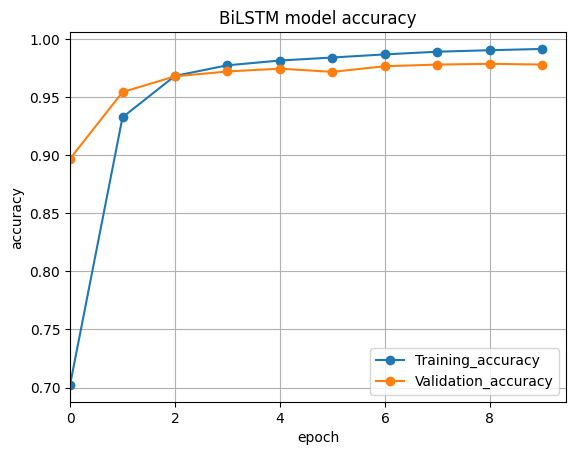

In [188]:
plt.plot(history_4.epoch, history_4.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('BiLSTM model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

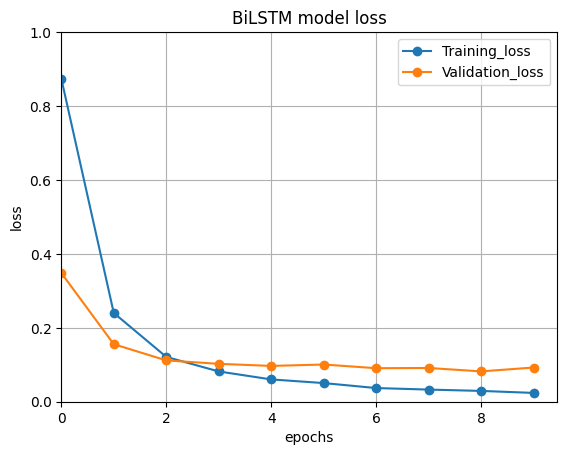

In [189]:
plt.plot(history_4.epoch, history_4.history['loss'], '-o', label='Training_loss')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='Validation_loss')
plt.legend()
plt.title('BiLSTM model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [190]:
# plot_classification_report(report)
# plt.savefig('BiLSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.close()

AVG. Cross validation

In [191]:
df_results_cross_val.loc['BiLSTM avg cross validation data test 80%'] = [f1_avg_bilstm, precision_avg_bilstm, recall_avg_bilstm, accuracy_avg_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.972387,0.972610,0.972387,0.972390,789.397488
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.972565,0.972851,0.972634,0.972634,78.939749
CNN-BiLSTM avg cross validation data train 80%,0.972443,0.972772,0.972443,0.972390,606.564159
CNN-BiLSTM avg cross validation data test 20%,0.976594,0.976754,0.976603,0.976603,60.656416
1D_CNN avg cross validation data test 80%,0.974981,0.975129,0.974981,0.975002,1202.455268
1D_CNN avg cross validation data test 20%,0.977870,0.977994,0.977857,0.977857,120.245527
BiLSTM avg cross validation data test 80%,0.970286,0.970638,0.970286,0.970300,1931.623662


In [192]:
# Test cross validation 20%
model_bisltm_cross_validate = load_model(bisltm_cross_validate_model_path)
predicted = model_bisltm_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
# y_test = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

150/150 [==============================] - 2s 12ms/step
Testing Accuracy: 0.967412
Testing Precision: 0.967981
Testing Recall: 0.967412
Testing F1 score: 0.967428


In [193]:

df_results_cross_val.loc['BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.972387,0.972610,0.972387,0.972390,789.397488
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.972565,0.972851,0.972634,0.972634,78.939749
CNN-BiLSTM avg cross validation data train 80%,0.972443,0.972772,0.972443,0.972390,606.564159
CNN-BiLSTM avg cross validation data test 20%,0.976594,0.976754,0.976603,0.976603,60.656416
1D_CNN avg cross validation data test 80%,0.974981,0.975129,0.974981,0.975002,1202.455268
1D_CNN avg cross validation data test 20%,0.977870,0.977994,0.977857,0.977857,120.245527
BiLSTM avg cross validation data test 80%,0.970286,0.970638,0.970286,0.970300,1931.623662
BiLSTM avg cross validation data test 20%,0.967428,0.967981,0.967412,0.967412,193.162366


## save the results in csv

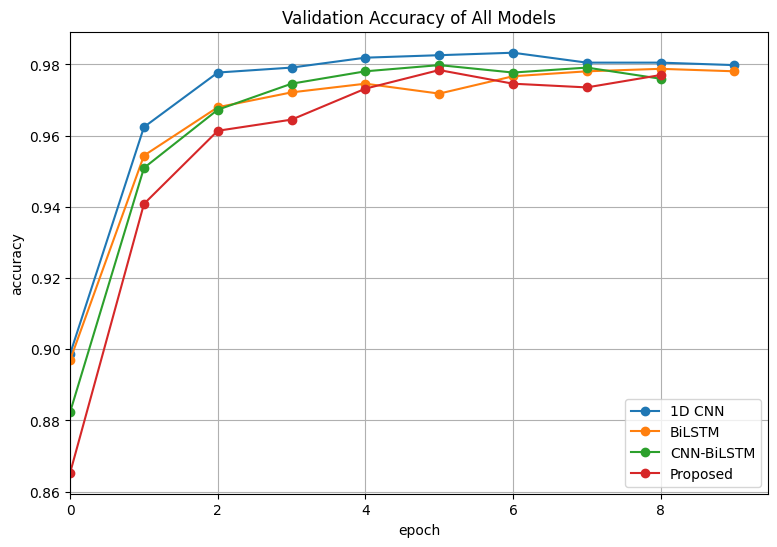

In [194]:
# plot overall accuracy on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='1D CNN')
# plt.plot(history_3.epoch, history_3.history['val_accuracy'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Proposed')
plt.title('Validation Accuracy of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

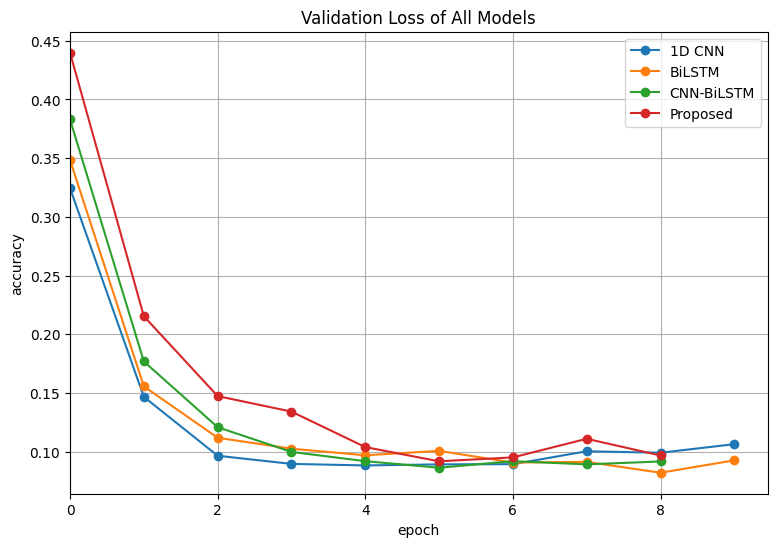

In [195]:
# plot overall looss on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='1D CNN')
# plt.plot(history_3.epoch, history_3.history['val_loss'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Proposed')
plt.title('Validation Loss of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()